In [78]:
%load_ext autoreload
%autoreload 2

import networkx as nx
import pandas as pd
import numpy as np
from krxns.net_construction import construct_reaction_network, extract_compounds
from krxns.config import filepaths
from krxns.utils import str2int
from krxns.cheminfo import expand_unpaired_cofactors, draw_reaction, draw_molecule, standardize_smiles
from krxns.networks import SuperMultiDiGraph
import json
from IPython.display import SVG

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
# Load unpaired cofs
unpaired_fp = filepaths['cofactors'] / "unpaired_cofactors_reference.tsv"
name_blacklist = [
    'acetyl-CoA',
]

unpaired_ref = pd.read_csv(
    filepath_or_buffer=unpaired_fp,
    sep='\t'
)

filtered_unpaired = unpaired_ref.loc[~unpaired_ref['Name'].isin(name_blacklist), :]
cofactors = expand_unpaired_cofactors(filtered_unpaired, k=10)

manual = {
    'N#N': 'N2',
    '[H][H]': 'H2',
    'S': 'hydrogen sufide',
    '[Cl-]': 'chloride',
    '[Na+]': 'sodium'
}

cofactors = {**cofactors, ** manual}

# Load cc sim mats
cc_sim_mats = {
    'mcs': np.load(filepaths['sim_mats'] / "mcs.npy"),
    'tanimoto': np.load(filepaths['sim_mats'] / "tanimoto.npy")
}

# Load known reaction data
with open(filepaths['data'] / 'sprhea_240310_v3_mapped.json', 'r') as f:
    krs = json.load(f)

# Load op connected reactions
with open(filepaths['connected_reactions'] / 'sprhea_240310_v3_mapped_operator.json', 'r') as f:
    op_cxns = str2int(json.load(f))

kcs, smi2id = extract_compounds(krs)

[11:02:45] WARNING: not removing hydrogen atom without neighbors


In [80]:
G = SuperMultiDiGraph()
edges, nodes = construct_reaction_network(operator_connections=op_cxns, reactions=krs, cofactors=cofactors)
G.add_nodes_from(nodes)
edge_keys = G.add_edges_from(edges)

In [81]:
def show_path(source, target, topk = 1):
    node_path, edge_path = G.shortest_path(source, target)
    for i, step in enumerate(edge_path):
        print(f"STEP #{i+1}")
        for edge in step[:topk]:
            print([(k, v) for k, v in edge.items() if k != 'smarts'])
            display(SVG(draw_reaction(edge['smarts'])))

STEP #1
[('rid', 11792), ('rhea_ids', [58058]), ('imt_rules', ['rule0031_7']), ('weight', 0.8333333333333334), ('requires', {'NCCS(=O)O': 1}), ('other_products', {'O=CCS(=O)O': 1})]


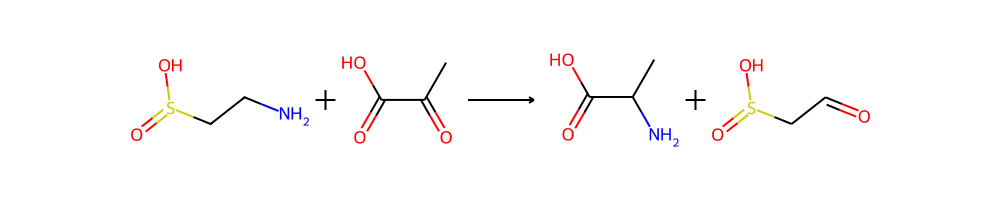

STEP #2
[('rid', 4866), ('rhea_ids', [12623]), ('imt_rules', ['rule0023_13']), ('weight', 0.6666666666666666), ('requires', {'O=C=O': 1}), ('other_products', {})]


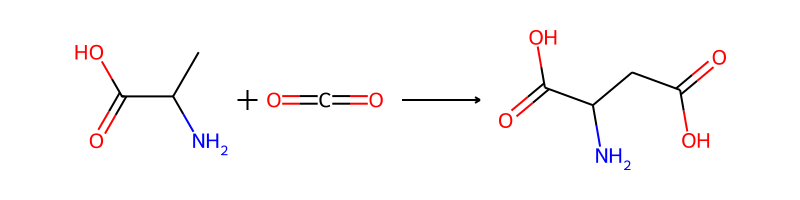

STEP #3
[('rid', 3406), ('rhea_ids', [16603]), ('imt_rules', ['rule0257_1']), ('weight', 1.0), ('requires', {}), ('other_products', {'N': 1})]


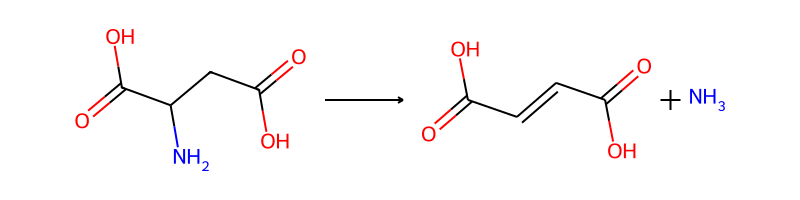

STEP #4
[('rid', 1638), ('rhea_ids', [40524]), ('imt_rules', ['rule0420_1']), ('weight', 1.0), ('requires', {'*c1c(*)c(O)c(*)c(*)c1O': 1}), ('other_products', {'*C1=C(*)C(=O)C(*)=C(*)C1=O': 1})]


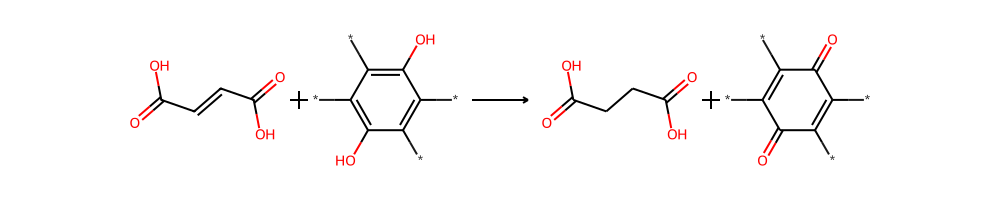

In [82]:
i = G.get_nodes_by_prop('name', 'pyruvate')[0]
j  = G.get_nodes_by_prop('name', 'succinate')[0]
show_path(i, j)

STEP #1
[('rid', 11066), ('rhea_ids', [53818]), ('imt_rules', ['rule0196_1']), ('weight', 0.5714285714285714), ('requires', {'NC(CS)C(=O)O': 1}), ('other_products', {'S': 1})]


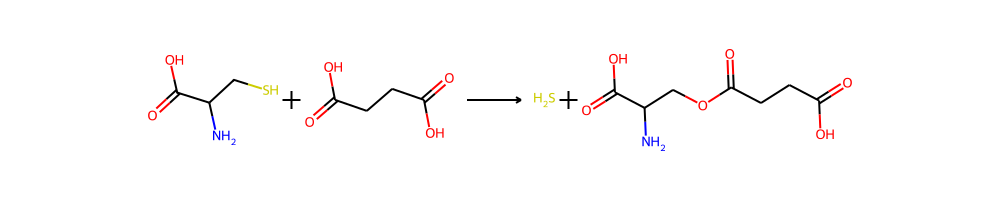

STEP #2
[('rid', 3995), ('rhea_ids', [52821]), ('imt_rules', ['rule0022_10']), ('weight', 1.0), ('requires', {'CC(C)(COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O)C(O)C(=O)NCCC(=O)NCCS': 1}), ('other_products', {'CC(C)(COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O)C(O)C(=O)NCCC(=O)NCCSC(=O)CCC(=O)O': 1})]


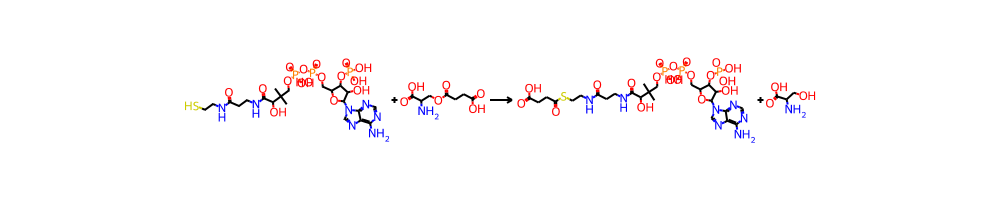

STEP #3
[('rid', 855), ('rhea_ids', [13978, 19170]), ('imt_rules', ['rule0341_1']), ('weight', 1.0), ('requires', {}), ('other_products', {'N': 1})]


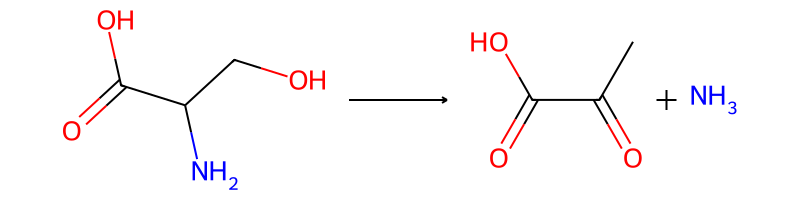

In [83]:
show_path(j, i)

STEP #1
[('rid', 12191), ('rhea_ids', [49637]), ('imt_rules', ['rule0145_5']), ('weight', 1.0), ('requires', {'OO': 1}), ('other_products', {'O': 1, 'O=O': 1})]


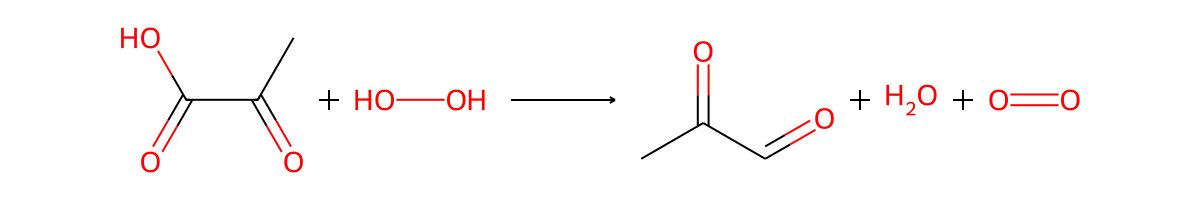

STEP #2
[('rid', 4467), ('rhea_ids', [27987]), ('imt_rules', ['rule0002_143']), ('weight', 1.0), ('requires', {'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1': 1}), ('other_products', {'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1': 1})]


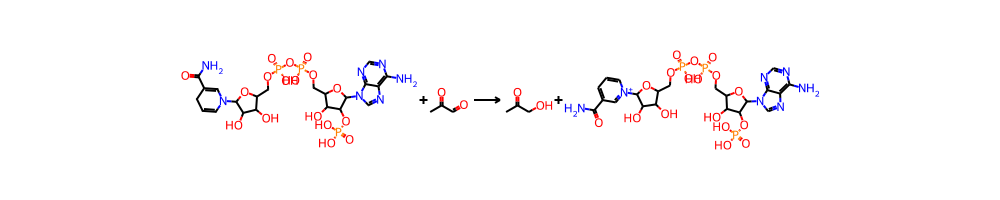

STEP #3
[('rid', 7031), ('rhea_ids', [55790]), ('imt_rules', ['rule0005_60']), ('weight', 1.0), ('requires', {'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1': 1, 'O': 1}), ('other_products', {'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1': 1, 'O=O': 1})]


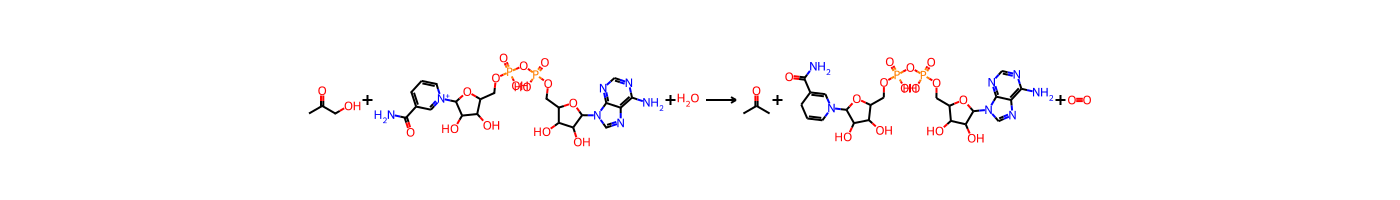

In [84]:
i = G.get_nodes_by_prop('name', 'pyruvate')[0]
j  = G.get_nodes_by_prop('name', 'acetone')[0]
show_path(i, j)

STEP #1
[('rid', 7031), ('rhea_ids', [55790]), ('imt_rules', ['rule0005_60']), ('weight', 0.8), ('requires', {'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1': 1, 'O=O': 1}), ('other_products', {'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1': 1, 'O': 1})]


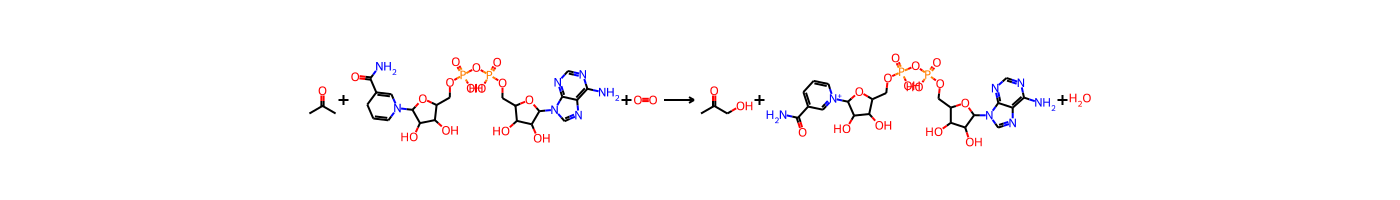

STEP #2
[('rid', 4467), ('rhea_ids', [27987]), ('imt_rules', ['rule0002_143']), ('weight', 1.0), ('requires', {'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1': 1}), ('other_products', {'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1': 1})]


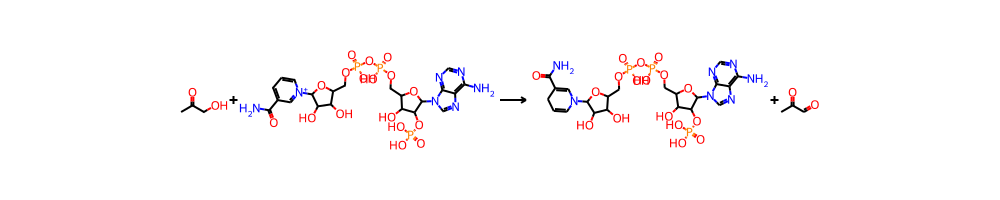

STEP #3
[('rid', 12191), ('rhea_ids', [49637]), ('imt_rules', ['rule0145_5']), ('weight', 0.8333333333333334), ('requires', {'O': 1, 'O=O': 1}), ('other_products', {'OO': 1})]


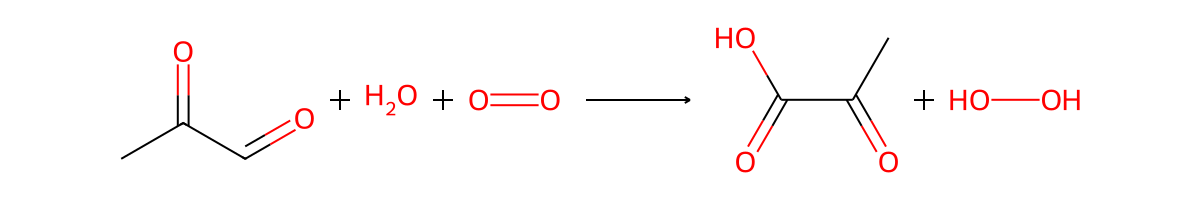

In [85]:
show_path(j, i)

STEP #1
[('rid', 4175), ('rhea_ids', [20765]), ('imt_rules', ['rule0126_1']), ('weight', 0.6666666666666666), ('requires', {'CC(C(=O)O)C(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O': 1}), ('other_products', {'CCC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O': 1})]


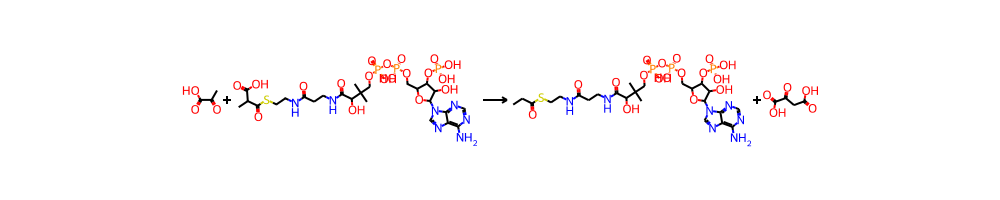

STEP #2
[('rid', 3111), ('rhea_ids', [10761]), ('imt_rules', ['rule0053_09']), ('weight', 0.6923076923076923), ('requires', {'CC(=O)O': 1}), ('other_products', {})]


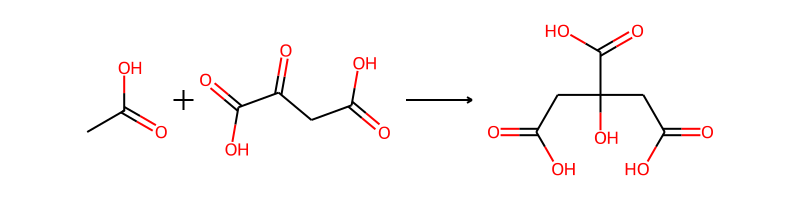

STEP #3
[('rid', 2323), ('rhea_ids', [40044]), ('imt_rules', ['rule0050_04']), ('weight', 0.5454545454545454), ('requires', {'NC(CCC(=O)O)C(=O)O': 1, 'Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O)O)C(O)C1O': 1}), ('other_products', {'Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)O)C(O)C1O': 1, 'O=P(O)(O)O': 1})]


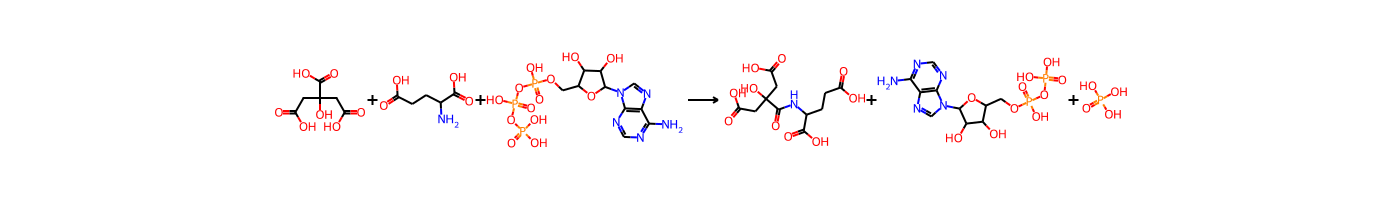

STEP #4
[('rid', 2323), ('rhea_ids', [40044]), ('imt_rules', ['rule0050_04']), ('weight', 1.0), ('requires', {'Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)O)C(O)C1O': 1, 'O=P(O)(O)O': 1}), ('other_products', {'O=C(O)CC(O)(CC(=O)O)C(=O)O': 1, 'Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O)O)C(O)C1O': 1})]


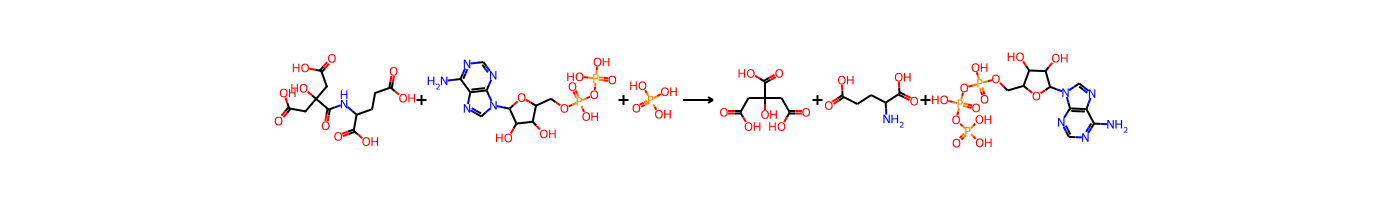

STEP #5
[('rid', 14801), ('rhea_ids', [10022]), ('imt_rules', ['rule0156_3']), ('weight', 0.5263157894736842), ('requires', {'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1': 1, 'NC(CCCC=O)C(=O)O': 1}), ('other_products', {'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1': 1, 'O': 1})]


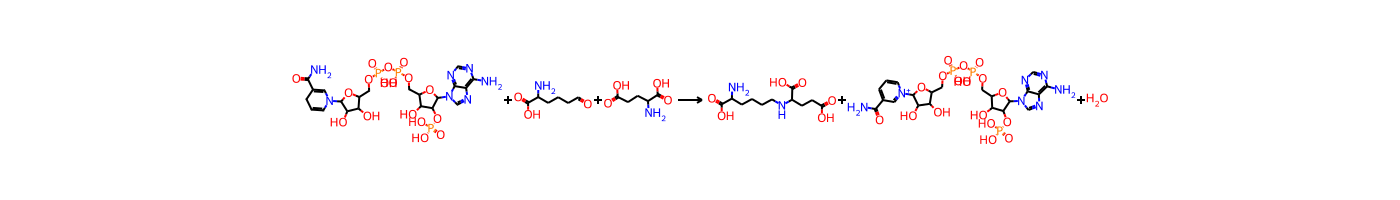

STEP #6
[('rid', 4447), ('rhea_ids', [12442]), ('imt_rules', ['rule0156_1']), ('weight', 1.0), ('requires', {'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1': 1, 'O': 1}), ('other_products', {'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1': 1, 'O=C(O)CCC(=O)C(=O)O': 1})]


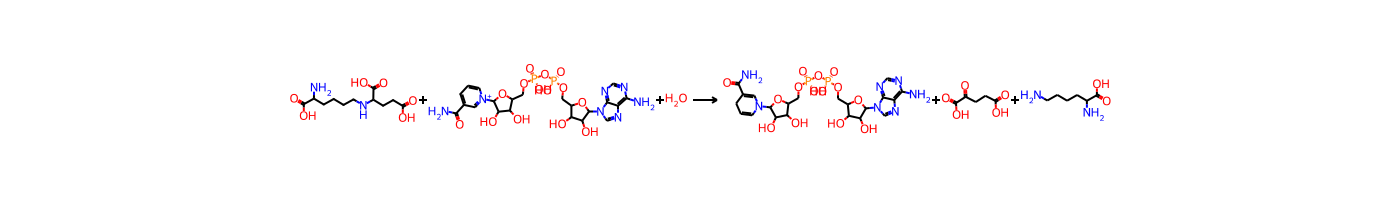

In [86]:
i = G.get_nodes_by_prop('name', 'pyruvate')[0]
j  = G.get_nodes_by_prop('name', 'L-lysine')[0]
show_path(i, j)

In [87]:
sorted([node['name'] for id, node in G.nodes(data=True)], key=lambda x : len(x))

['',
 '',
 '',
 'FMN',
 'FAD',
 'TDP',
 'TTP',
 'CMP',
 'CDP',
 'CTP',
 'GMP',
 'GDP',
 'GTP',
 'AMP',
 'ADP',
 'ATP',
 'XMP',
 'IDP',
 'ITP',
 'UMP',
 'UDP',
 'UTP',
 'dTMP',
 'dTDP',
 'dTTP',
 'NADH',
 'urea',
 'dZMP',
 'dZDP',
 'dZTP',
 'dGMP',
 'dGTP',
 'dADP',
 'dATP',
 'taxol',
 'OPC-6',
 'SN-38',
 'NADPH',
 'DIBOA',
 'Lc4Cer',
 'heme b',
 'phytol',
 'citral',
 'prenol',
 'lutein',
 'mogrol',
 'DIMBOA',
 'emodin',
 'harmol',
 'biuret',
 'NAD(+)',
 'L-dopa',
 'A47934',
 "3'-GMP",
 "3'-AMP",
 'benzil',
 'biotin',
 'uracil',
 'phenol',
 'indole',
 'a thiol',
 'methane',
 'steviol',
 'propene',
 'styrene',
 'acetate',
 'acetone',
 'lactate',
 'estrone',
 'propane',
 'tylosin',
 'butanal',
 'hexanal',
 'heptane',
 'octanal',
 'nonanal',
 'decanal',
 'ethanol',
 'tropine',
 'loganin',
 'cocaine',
 'velutin',
 'questin',
 'pilosin',
 'codeine',
 'choline',
 'thymine',
 'toluene',
 'dhurrin',
 'oxamate',
 'triuret',
 'NADP(+)',
 'serinol',
 'glycine',
 'neamine',
 'taurine',
 'aniline',


In [103]:
smi = standardize_smiles('CC(C)(CO)[C@@H](O)C(=O)NCCC(=O)[O-]') # CCC(C)(C)C(=O)SCCC(=O)OC
ids = G.get_nodes_by_prop('smiles', smi)
ids

[11:25:08] Initializing MetalDisconnector
[11:25:08] Running MetalDisconnector
[11:25:08] Initializing Normalizer
[11:25:08] Running Normalizer
[11:25:08] Initializing MetalDisconnector
[11:25:08] Running MetalDisconnector
[11:25:08] Initializing Normalizer
[11:25:08] Running Normalizer
[11:25:08] Running LargestFragmentChooser


[2386]

beta-alanine


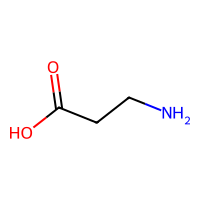

3-oxopropanoate


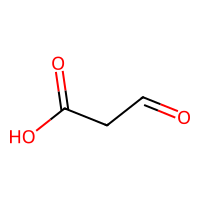

beta-alaninamide


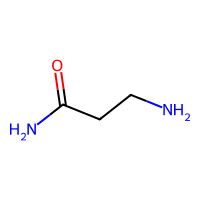

cysteamine


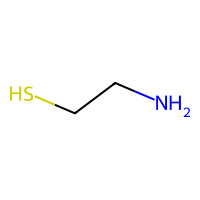

3-aminopropanal


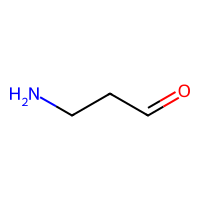

2-dehydropantoate


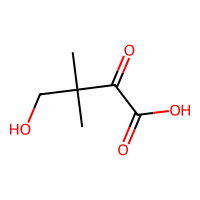

(R)-pantetheine


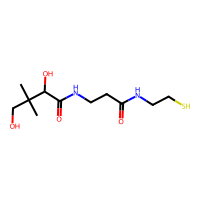

3-(carbamoylamino)propanoate


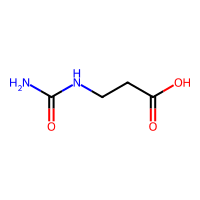

3-guanidinopropanoate


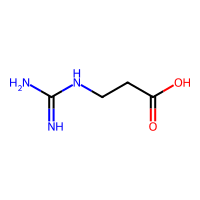

(R)-pantothenate


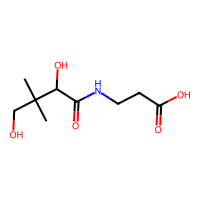

(R)-pantoate


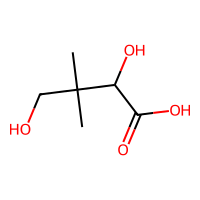

L-aspartate


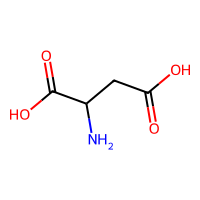

(R)-4'-phosphopantetheine


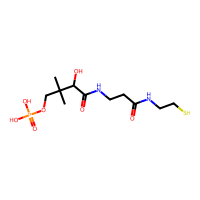

N-[(R)-4-phosphopantothenoyl]-L-cysteine


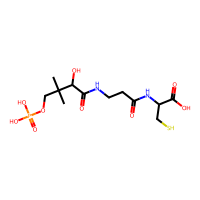

(R)-4'-phosphopantothenate


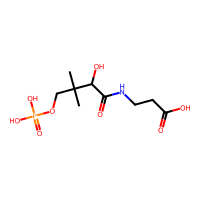

(R)-4-phosphopantoate


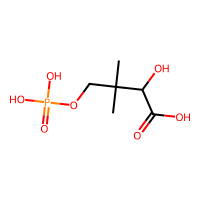

In [104]:
n = 2
id = ids[0]
n_hop_neighbors = nx.ego_graph(G, id, radius=n)
for i in n_hop_neighbors:
    print(G.nodes[i]['name'])
    display(SVG(draw_molecule(G.nodes[i]['smiles'])))

PATH FROM beta-alanine


STEP #1
[('rid', 2384), ('rhea_ids', [14078]), ('imt_rules', ['rule0031_6']), ('weight', 0.8333333333333334), ('requires', {'CC(=O)C(=O)O': 1}), ('other_products', {'CC(N)C(=O)O': 1})]


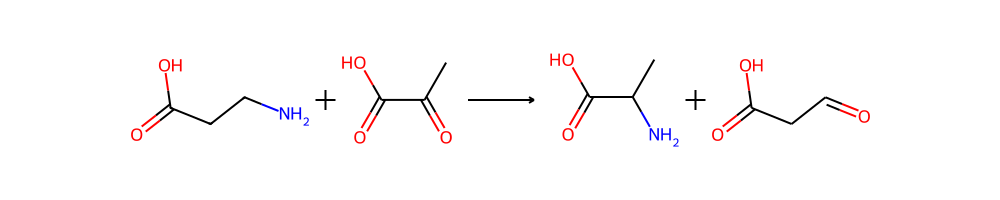

STEP #2
[('rid', 6573), ('rhea_ids', [26448]), ('imt_rules', ['rule0143_1']), ('weight', 0.1111111111111111), ('requires', {'CC(C)(COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O)C(O)C(=O)NCCC(=O)NCCS': 1, 'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1': 1}), ('other_products', {'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1': 1})]


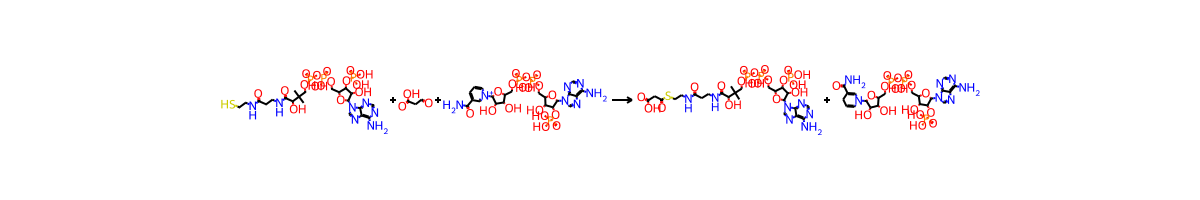

STEP #3
[('rid', 1395), ('rhea_ids', [67469]), ('imt_rules', ['rule0125_1']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'CC(C)(COP(=O)(O)O)C(O)C(=O)NCCC(=O)NCCSC(=O)CC(=O)O': 1})]


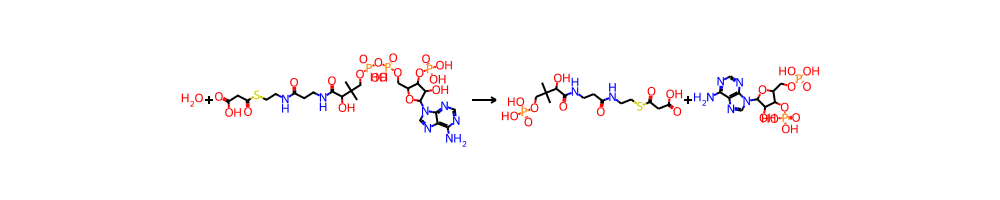

STEP #4
[('rid', 112), ('rhea_ids', [10041]), ('imt_rules', ['rule0016_042']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'O=P(O)(O)O': 1})]


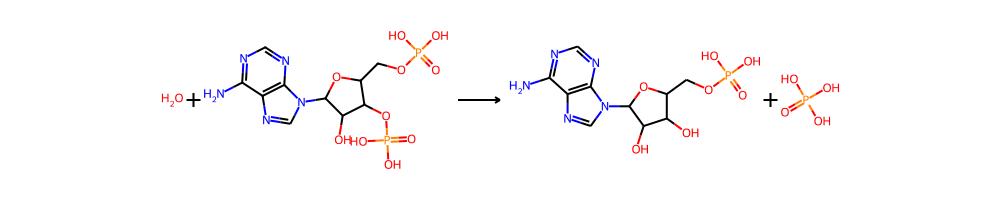

STEP #5
[('rid', 661), ('rhea_ids', [11801]), ('imt_rules', ['rule0125_1']), ('weight', 0.5227272727272727), ('requires', {'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)O)C(O)C2O)c1': 1}), ('other_products', {'O': 1})]


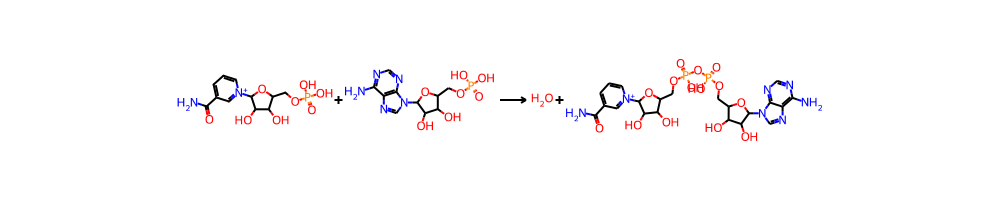

STEP #6
[('rid', 1224), ('rhea_ids', [60882, 60894]), ('imt_rules', ['rule0006_166']), ('weight', 0.7413793103448276), ('requires', {'*OC1C(COP(=O)(O)O)OC(*)C1O': 1}), ('other_products', {'O': 1})]


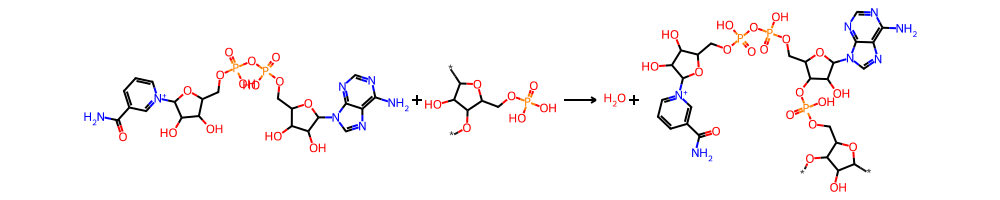

STEP #7
[('rid', 2781), ('rhea_ids', [60877]), ('imt_rules', ['rule0125_1']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)O)C(O)C2O)c1': 1})]


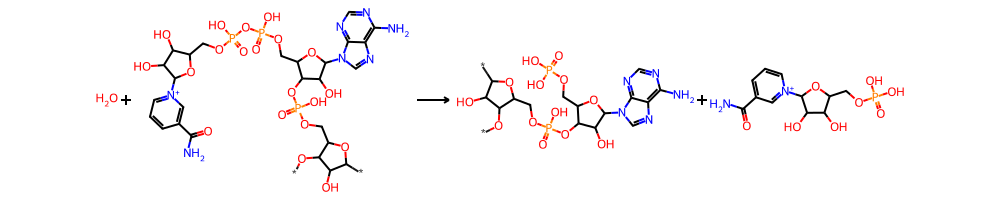

STEP #8
[('rid', 2927), ('rhea_ids', [67594]), ('imt_rules', ['rule0124_25']), ('weight', 0.6379310344827587), ('requires', {'CC(C)(COP(=O)(O)O)C(O)C(=O)NCCC(=O)NCCS': 1}), ('other_products', {'O': 1})]


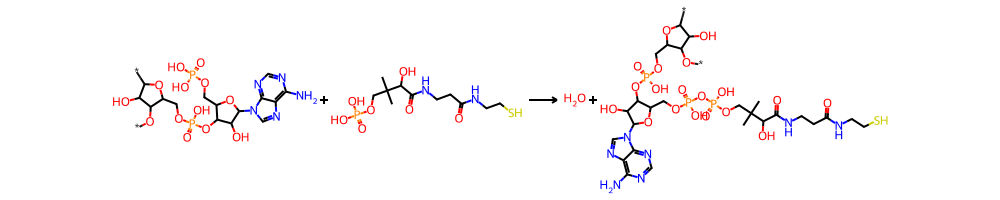

STEP #9
[('rid', 2927), ('rhea_ids', [67594]), ('imt_rules', ['rule0124_25']), ('weight', 0.9545454545454546), ('requires', {'O': 1}), ('other_products', {'*OC1C(COP(=O)(O)OC2C(COP(=O)(O)O)OC(n3cnc4c(N)ncnc43)C2O)OC(*)C1O': 1})]


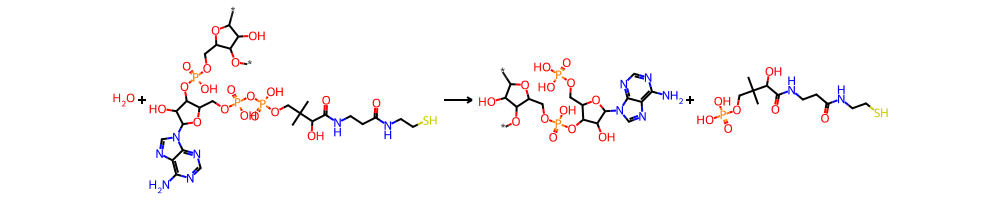

STEP #10
[('rid', 7118), ('rhea_ids', [68329]), ('imt_rules', ['rule0016_114']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'O=P(O)(O)O': 1})]


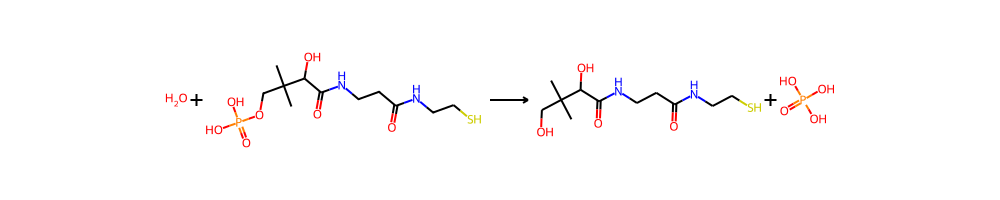

STEP #11
[('rid', 12970), ('rhea_ids', [13447]), ('imt_rules', ['rule0012_264']), ('weight', 0.9333333333333333), ('requires', {'O': 1}), ('other_products', {'NCCS': 1})]


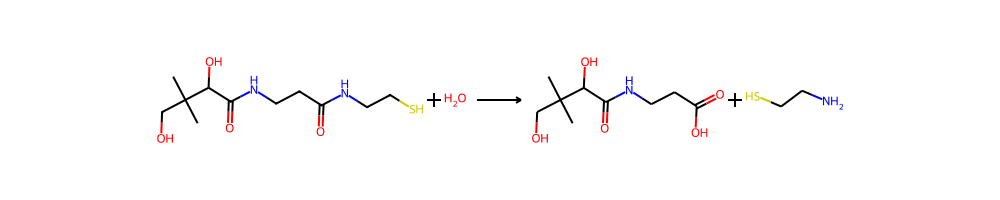

PATH FROM 3-oxopropanoate
STEP #1
[('rid', 6573), ('rhea_ids', [26448]), ('imt_rules', ['rule0143_1']), ('weight', 0.1111111111111111), ('requires', {'CC(C)(COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O)C(O)C(=O)NCCC(=O)NCCS': 1, 'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1': 1}), ('other_products', {'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1': 1})]


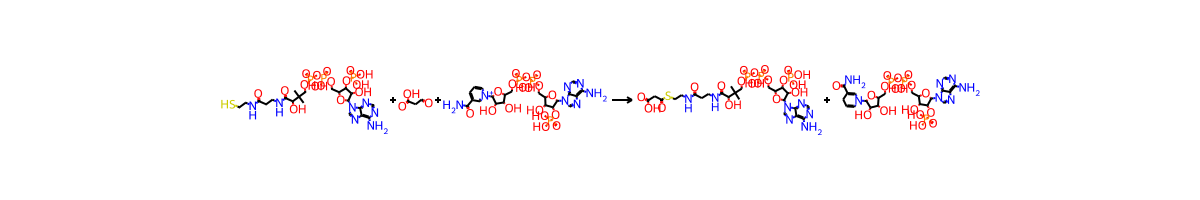

STEP #2
[('rid', 1395), ('rhea_ids', [67469]), ('imt_rules', ['rule0125_1']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'CC(C)(COP(=O)(O)O)C(O)C(=O)NCCC(=O)NCCSC(=O)CC(=O)O': 1})]


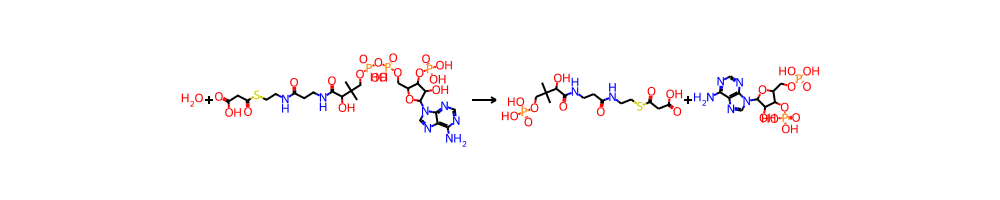

STEP #3
[('rid', 112), ('rhea_ids', [10041]), ('imt_rules', ['rule0016_042']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'O=P(O)(O)O': 1})]


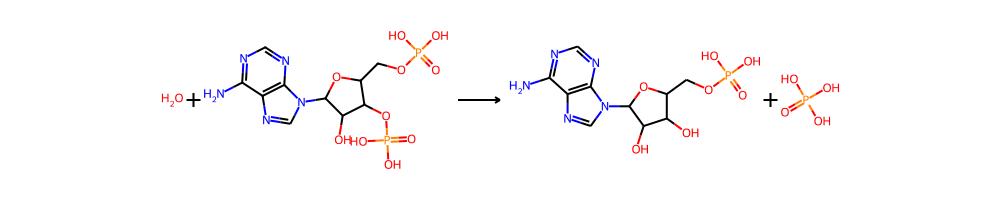

STEP #4
[('rid', 661), ('rhea_ids', [11801]), ('imt_rules', ['rule0125_1']), ('weight', 0.5227272727272727), ('requires', {'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)O)C(O)C2O)c1': 1}), ('other_products', {'O': 1})]


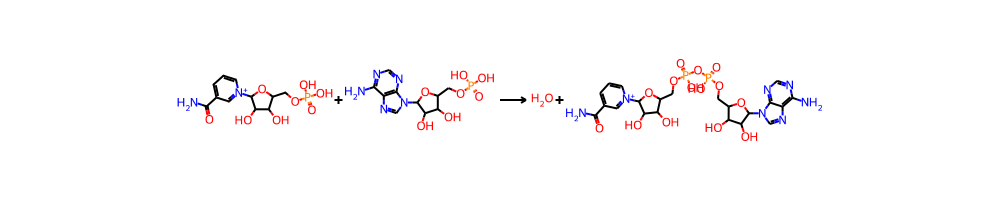

STEP #5
[('rid', 1224), ('rhea_ids', [60882, 60894]), ('imt_rules', ['rule0006_166']), ('weight', 0.7413793103448276), ('requires', {'*OC1C(COP(=O)(O)O)OC(*)C1O': 1}), ('other_products', {'O': 1})]


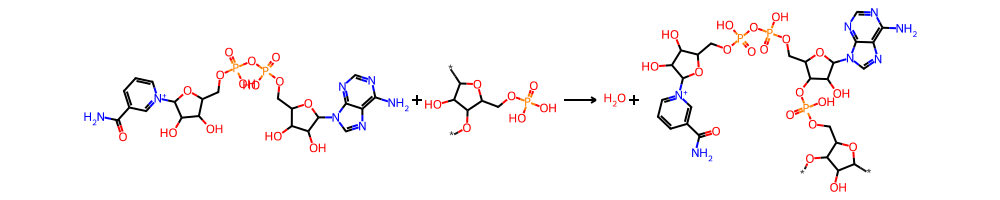

STEP #6
[('rid', 2781), ('rhea_ids', [60877]), ('imt_rules', ['rule0125_1']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)O)C(O)C2O)c1': 1})]


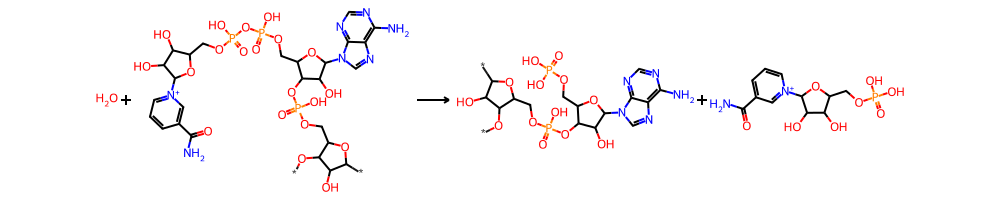

STEP #7
[('rid', 2927), ('rhea_ids', [67594]), ('imt_rules', ['rule0124_25']), ('weight', 0.6379310344827587), ('requires', {'CC(C)(COP(=O)(O)O)C(O)C(=O)NCCC(=O)NCCS': 1}), ('other_products', {'O': 1})]


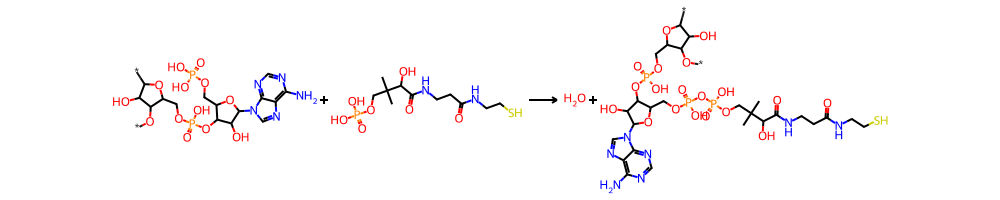

STEP #8
[('rid', 2927), ('rhea_ids', [67594]), ('imt_rules', ['rule0124_25']), ('weight', 0.9545454545454546), ('requires', {'O': 1}), ('other_products', {'*OC1C(COP(=O)(O)OC2C(COP(=O)(O)O)OC(n3cnc4c(N)ncnc43)C2O)OC(*)C1O': 1})]


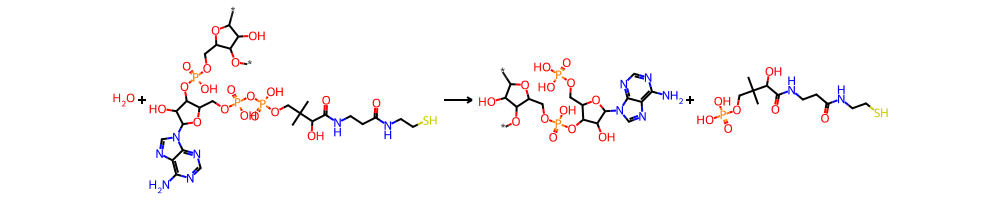

STEP #9
[('rid', 7118), ('rhea_ids', [68329]), ('imt_rules', ['rule0016_114']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'O=P(O)(O)O': 1})]


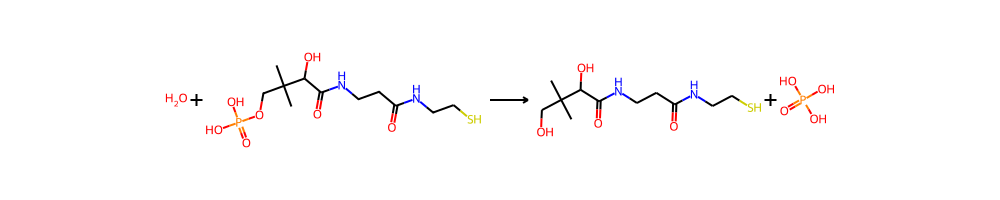

STEP #10
[('rid', 12970), ('rhea_ids', [13447]), ('imt_rules', ['rule0012_264']), ('weight', 0.9333333333333333), ('requires', {'O': 1}), ('other_products', {'NCCS': 1})]


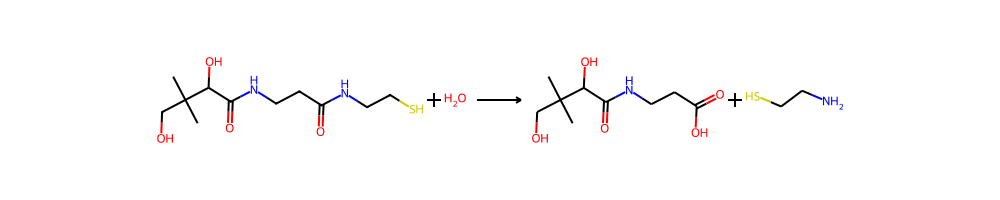

PATH FROM beta-alaninamide
STEP #1
[('rid', 18915), ('rhea_ids', [26548]), ('imt_rules', ['rule0055_2']), ('weight', 0.8333333333333334), ('requires', {'O': 1}), ('other_products', {'N': 1})]


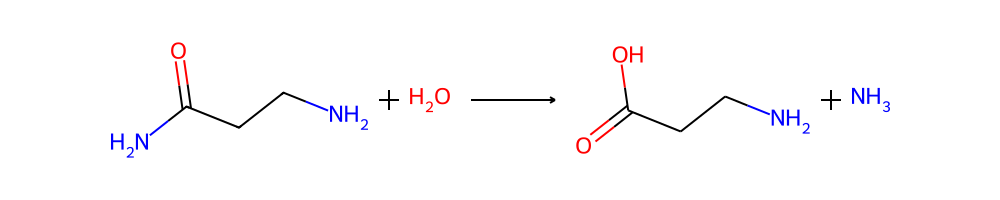

STEP #2
[('rid', 2384), ('rhea_ids', [14078]), ('imt_rules', ['rule0031_6']), ('weight', 0.8333333333333334), ('requires', {'CC(=O)C(=O)O': 1}), ('other_products', {'CC(N)C(=O)O': 1})]


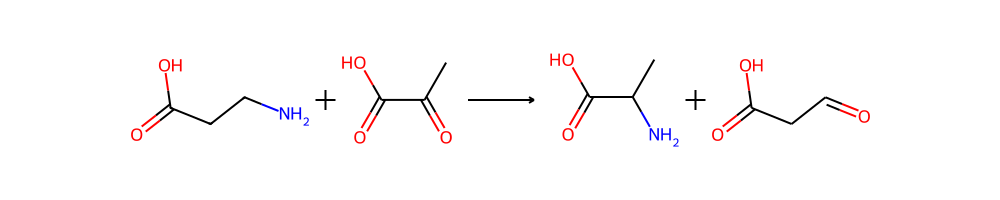

STEP #3
[('rid', 6573), ('rhea_ids', [26448]), ('imt_rules', ['rule0143_1']), ('weight', 0.1111111111111111), ('requires', {'CC(C)(COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O)C(O)C(=O)NCCC(=O)NCCS': 1, 'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1': 1}), ('other_products', {'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1': 1})]


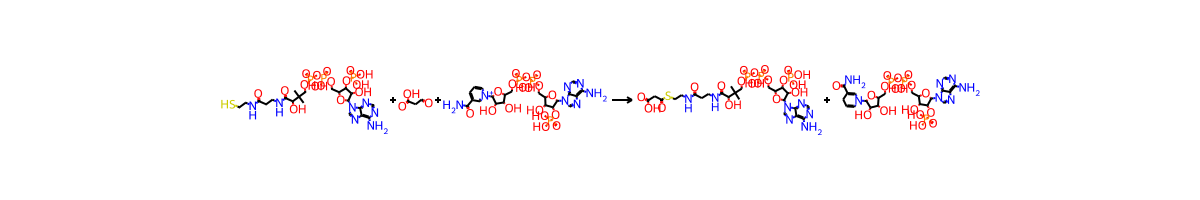

STEP #4
[('rid', 1395), ('rhea_ids', [67469]), ('imt_rules', ['rule0125_1']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'CC(C)(COP(=O)(O)O)C(O)C(=O)NCCC(=O)NCCSC(=O)CC(=O)O': 1})]


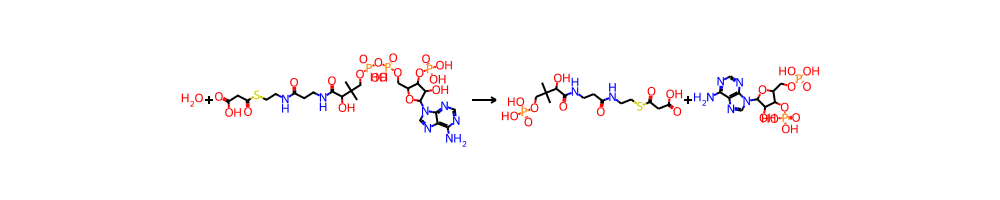

STEP #5
[('rid', 112), ('rhea_ids', [10041]), ('imt_rules', ['rule0016_042']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'O=P(O)(O)O': 1})]


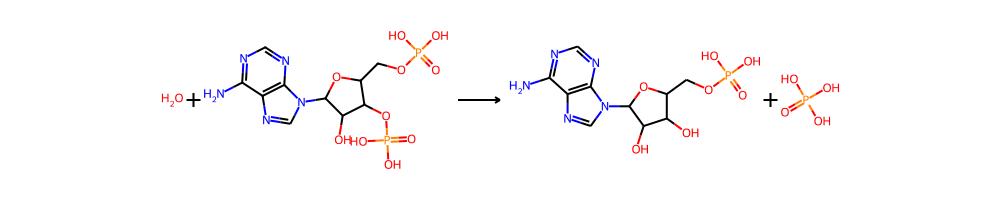

STEP #6
[('rid', 661), ('rhea_ids', [11801]), ('imt_rules', ['rule0125_1']), ('weight', 0.5227272727272727), ('requires', {'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)O)C(O)C2O)c1': 1}), ('other_products', {'O': 1})]


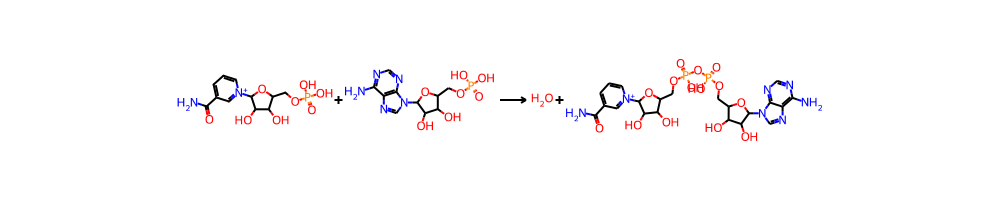

STEP #7
[('rid', 1224), ('rhea_ids', [60882, 60894]), ('imt_rules', ['rule0006_166']), ('weight', 0.7413793103448276), ('requires', {'*OC1C(COP(=O)(O)O)OC(*)C1O': 1}), ('other_products', {'O': 1})]


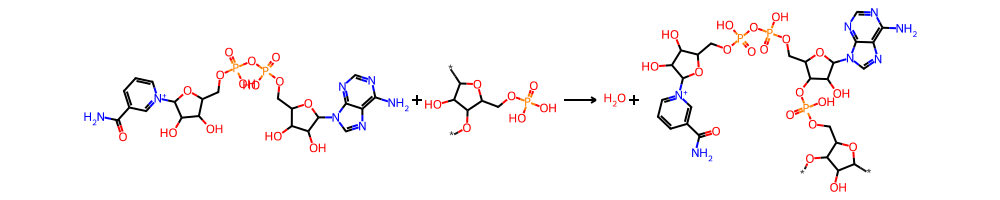

STEP #8
[('rid', 2781), ('rhea_ids', [60877]), ('imt_rules', ['rule0125_1']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)O)C(O)C2O)c1': 1})]


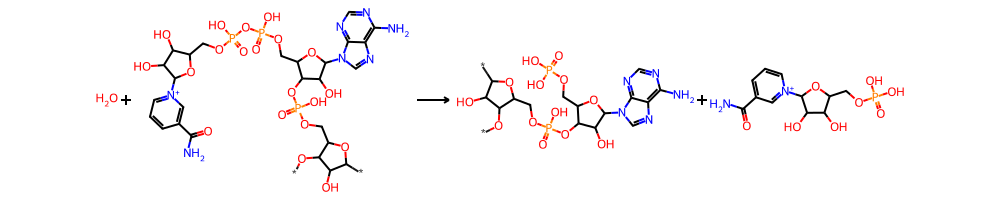

STEP #9
[('rid', 2927), ('rhea_ids', [67594]), ('imt_rules', ['rule0124_25']), ('weight', 0.6379310344827587), ('requires', {'CC(C)(COP(=O)(O)O)C(O)C(=O)NCCC(=O)NCCS': 1}), ('other_products', {'O': 1})]


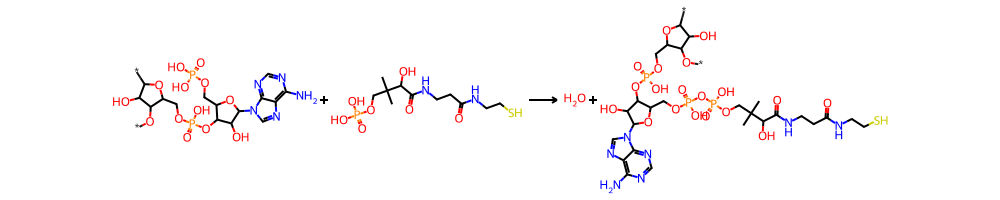

STEP #10
[('rid', 2927), ('rhea_ids', [67594]), ('imt_rules', ['rule0124_25']), ('weight', 0.9545454545454546), ('requires', {'O': 1}), ('other_products', {'*OC1C(COP(=O)(O)OC2C(COP(=O)(O)O)OC(n3cnc4c(N)ncnc43)C2O)OC(*)C1O': 1})]


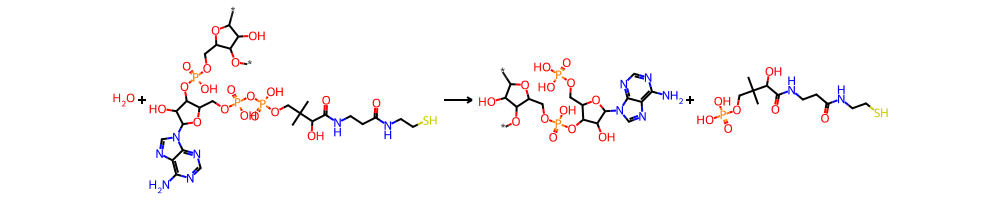

STEP #11
[('rid', 7118), ('rhea_ids', [68329]), ('imt_rules', ['rule0016_114']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'O=P(O)(O)O': 1})]


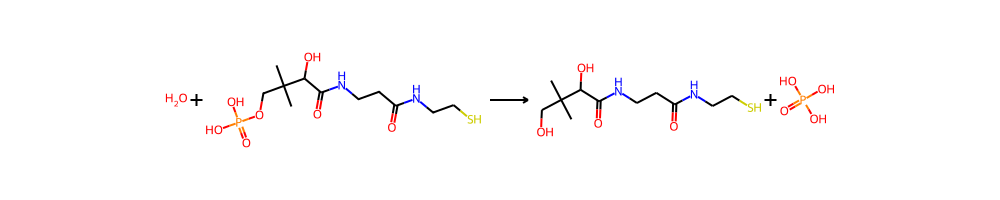

STEP #12
[('rid', 12970), ('rhea_ids', [13447]), ('imt_rules', ['rule0012_264']), ('weight', 0.9333333333333333), ('requires', {'O': 1}), ('other_products', {'NCCS': 1})]


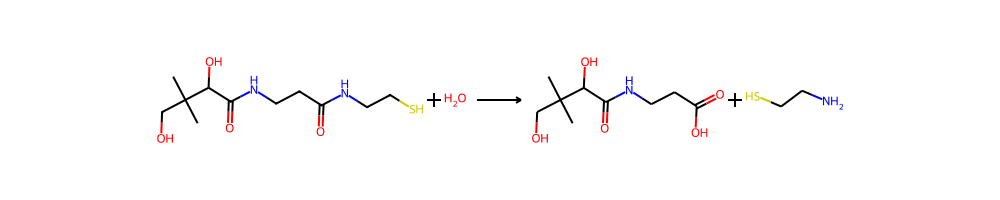

PATH FROM cysteamine
STEP #1
[('rid', 15716), ('rhea_ids', [27748]), ('imt_rules', ['rule0023_20']), ('weight', 0.5714285714285714), ('requires', {'O=C=O': 1}), ('other_products', {})]


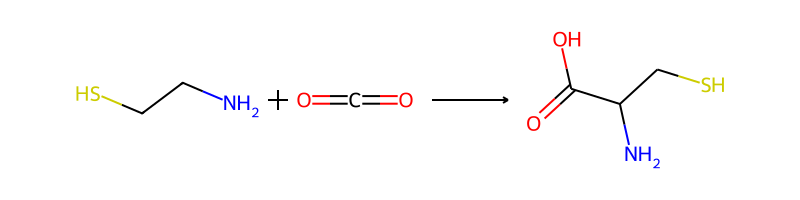

STEP #2
[('rid', 2611), ('rhea_ids', [14831]), ('imt_rules', ['rule0196_1']), ('weight', 0.6), ('requires', {'CC(=O)O': 1}), ('other_products', {'S': 1})]


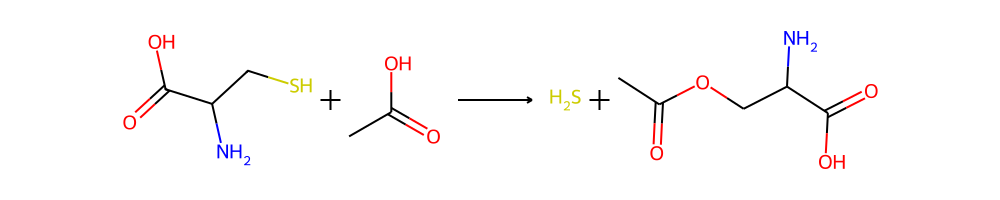

STEP #3
[('rid', 1891), ('rhea_ids', [24561]), ('imt_rules', ['rule0062_15']), ('weight', 0.058823529411764705), ('requires', {'CC(C)(COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O)C(O)C(=O)NCCC(=O)NCCS': 1}), ('other_products', {'NC(CO)C(=O)O': 1})]


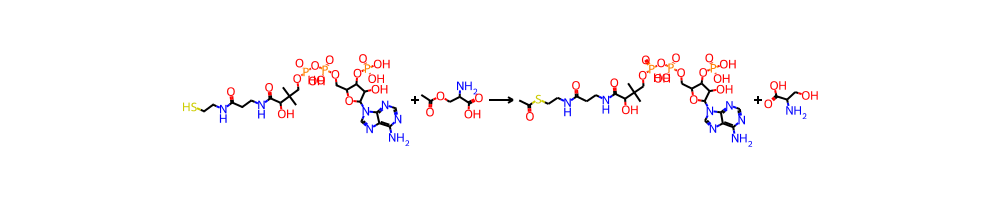

STEP #4
[('rid', 8650), ('rhea_ids', [30073]), ('imt_rules', ['rule0151_1']), ('weight', 0.9056603773584906), ('requires', {'CCCC(=O)O': 1}), ('other_products', {'CC(=O)O': 1})]


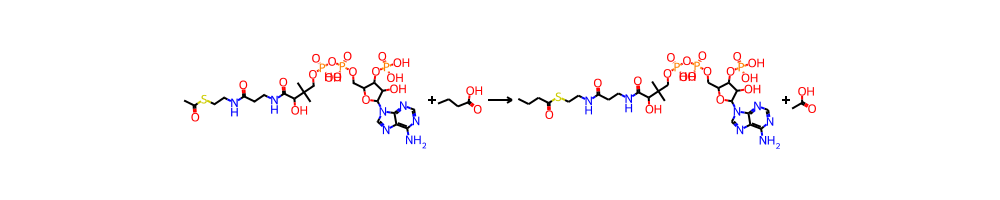

STEP #5
[('rid', 2512), ('rhea_ids', [49977]), ('imt_rules', ['rule0125_1']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'CCCC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)O': 1})]


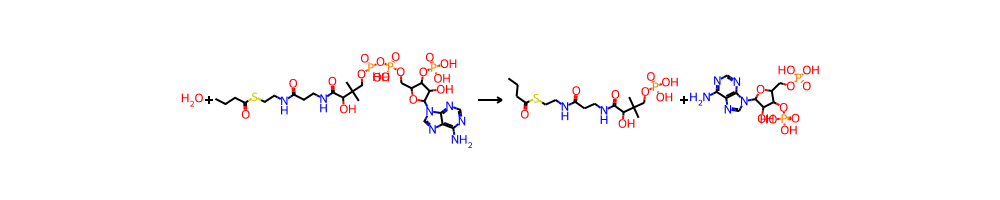

STEP #6
[('rid', 112), ('rhea_ids', [10041]), ('imt_rules', ['rule0016_042']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'O=P(O)(O)O': 1})]


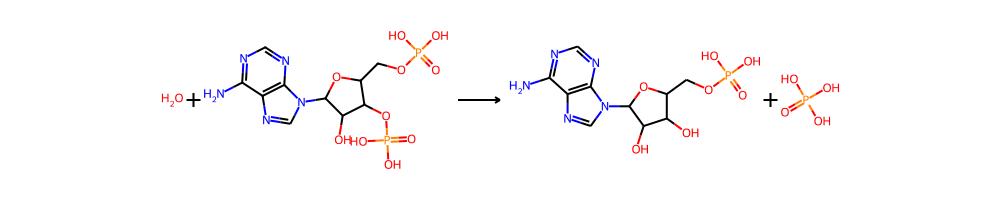

STEP #7
[('rid', 661), ('rhea_ids', [11801]), ('imt_rules', ['rule0125_1']), ('weight', 0.5227272727272727), ('requires', {'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)O)C(O)C2O)c1': 1}), ('other_products', {'O': 1})]


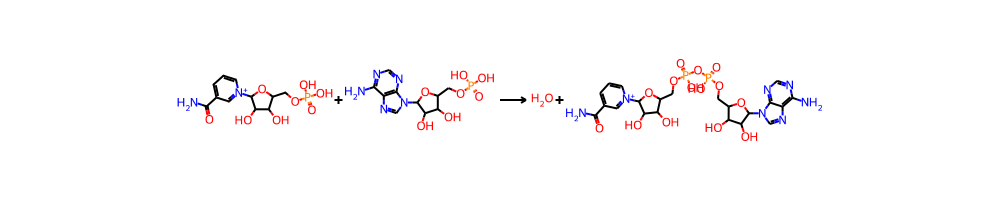

STEP #8
[('rid', 1224), ('rhea_ids', [60882, 60894]), ('imt_rules', ['rule0006_166']), ('weight', 0.7413793103448276), ('requires', {'*OC1C(COP(=O)(O)O)OC(*)C1O': 1}), ('other_products', {'O': 1})]


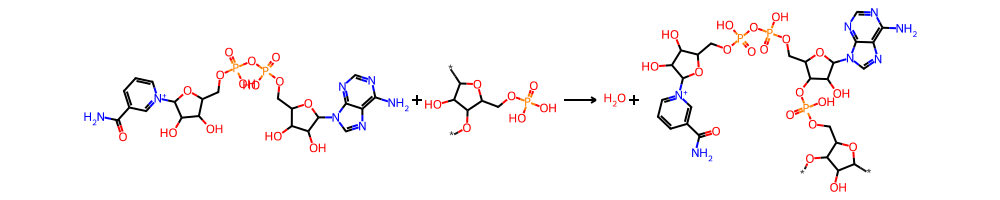

STEP #9
[('rid', 2781), ('rhea_ids', [60877]), ('imt_rules', ['rule0125_1']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)O)C(O)C2O)c1': 1})]


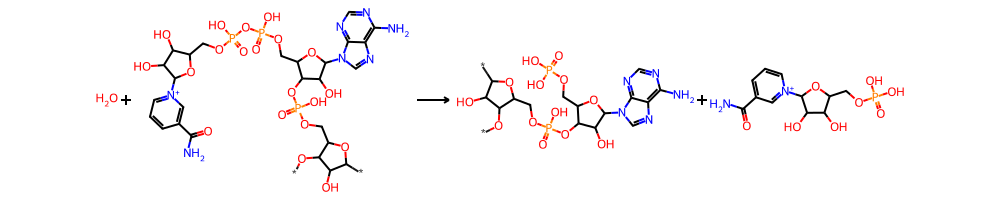

STEP #10
[('rid', 2927), ('rhea_ids', [67594]), ('imt_rules', ['rule0124_25']), ('weight', 0.6379310344827587), ('requires', {'CC(C)(COP(=O)(O)O)C(O)C(=O)NCCC(=O)NCCS': 1}), ('other_products', {'O': 1})]


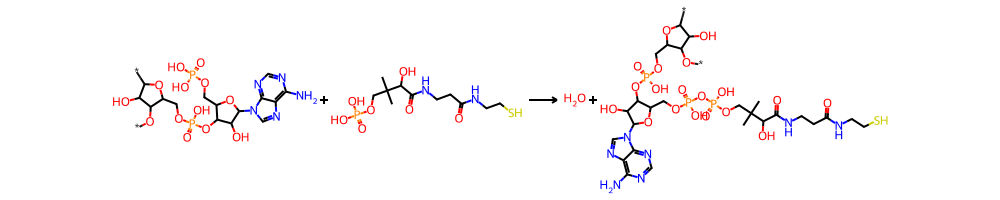

STEP #11
[('rid', 2927), ('rhea_ids', [67594]), ('imt_rules', ['rule0124_25']), ('weight', 0.9545454545454546), ('requires', {'O': 1}), ('other_products', {'*OC1C(COP(=O)(O)OC2C(COP(=O)(O)O)OC(n3cnc4c(N)ncnc43)C2O)OC(*)C1O': 1})]


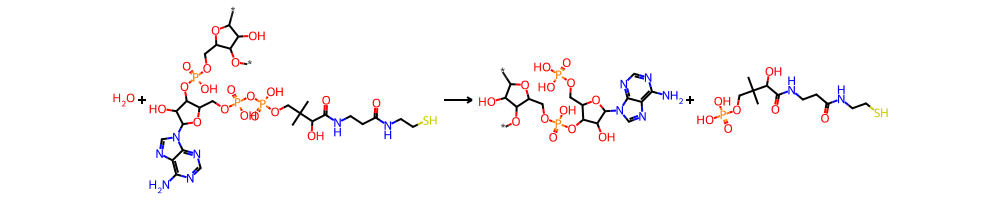

STEP #12
[('rid', 7118), ('rhea_ids', [68329]), ('imt_rules', ['rule0016_114']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'O=P(O)(O)O': 1})]


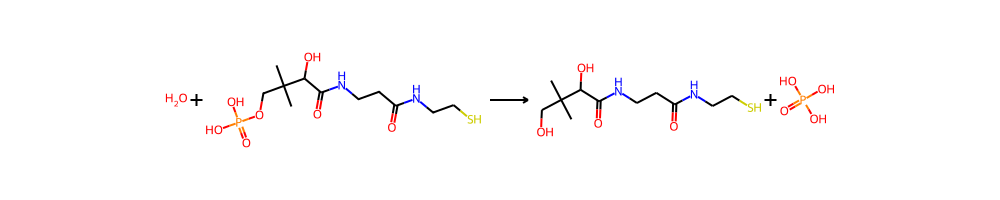

STEP #13
[('rid', 12970), ('rhea_ids', [13447]), ('imt_rules', ['rule0012_264']), ('weight', 0.9333333333333333), ('requires', {'O': 1}), ('other_products', {'NCCS': 1})]


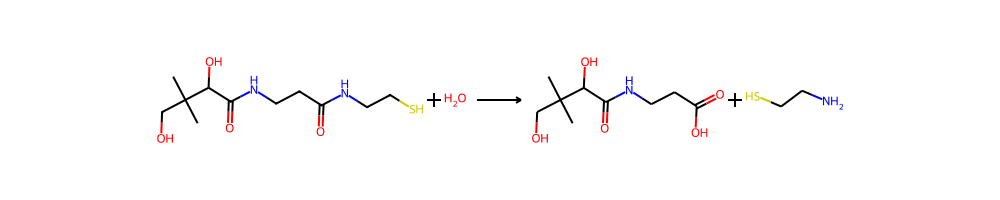

PATH FROM 3-aminopropanal
STEP #1
[('rid', 6693), ('rhea_ids', [30696]), ('imt_rules', ['rule0026_15']), ('weight', 0.8333333333333334), ('requires', {'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1': 1, 'O': 1}), ('other_products', {'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1': 1})]


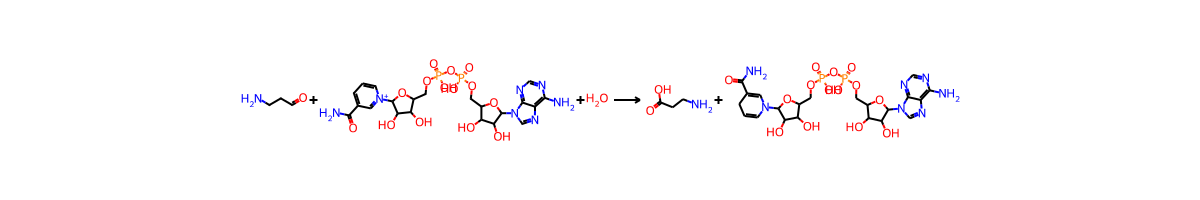

STEP #2
[('rid', 2384), ('rhea_ids', [14078]), ('imt_rules', ['rule0031_6']), ('weight', 0.8333333333333334), ('requires', {'CC(=O)C(=O)O': 1}), ('other_products', {'CC(N)C(=O)O': 1})]


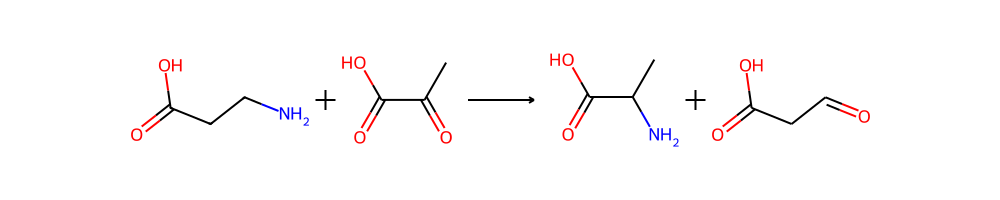

STEP #3
[('rid', 6573), ('rhea_ids', [26448]), ('imt_rules', ['rule0143_1']), ('weight', 0.1111111111111111), ('requires', {'CC(C)(COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O)C(O)C(=O)NCCC(=O)NCCS': 1, 'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1': 1}), ('other_products', {'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1': 1})]


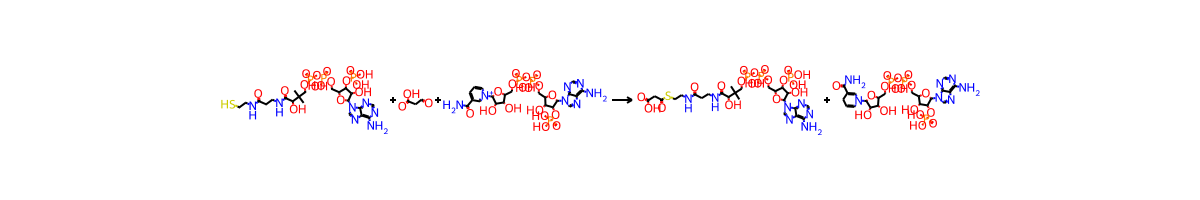

STEP #4
[('rid', 1395), ('rhea_ids', [67469]), ('imt_rules', ['rule0125_1']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'CC(C)(COP(=O)(O)O)C(O)C(=O)NCCC(=O)NCCSC(=O)CC(=O)O': 1})]


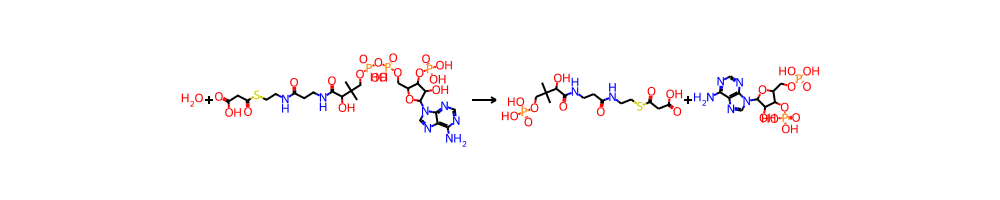

STEP #5
[('rid', 112), ('rhea_ids', [10041]), ('imt_rules', ['rule0016_042']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'O=P(O)(O)O': 1})]


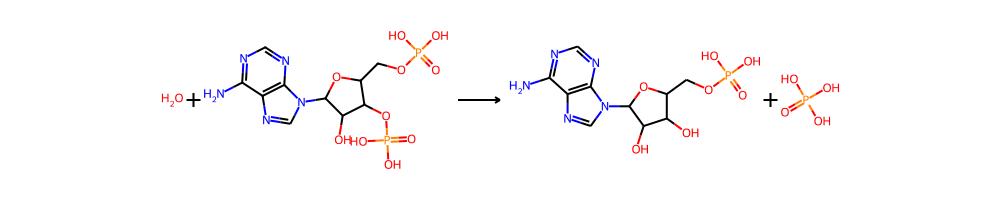

STEP #6
[('rid', 661), ('rhea_ids', [11801]), ('imt_rules', ['rule0125_1']), ('weight', 0.5227272727272727), ('requires', {'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)O)C(O)C2O)c1': 1}), ('other_products', {'O': 1})]


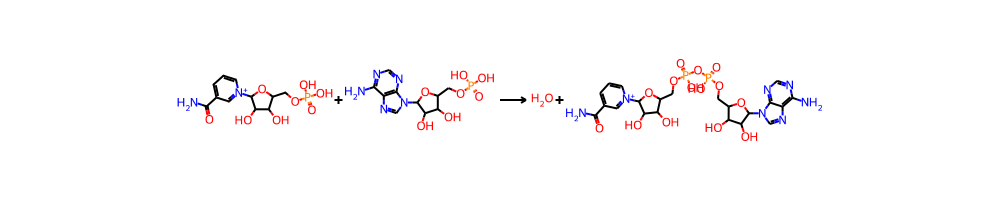

STEP #7
[('rid', 1224), ('rhea_ids', [60882, 60894]), ('imt_rules', ['rule0006_166']), ('weight', 0.7413793103448276), ('requires', {'*OC1C(COP(=O)(O)O)OC(*)C1O': 1}), ('other_products', {'O': 1})]


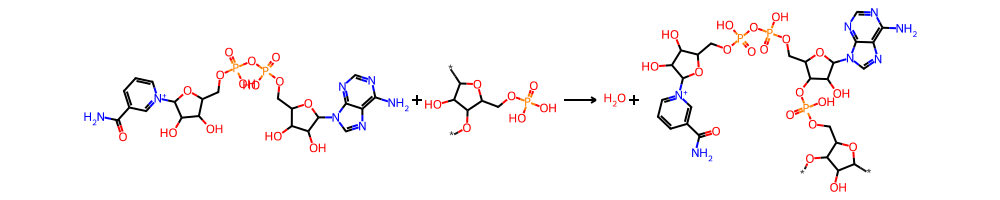

STEP #8
[('rid', 2781), ('rhea_ids', [60877]), ('imt_rules', ['rule0125_1']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)O)C(O)C2O)c1': 1})]


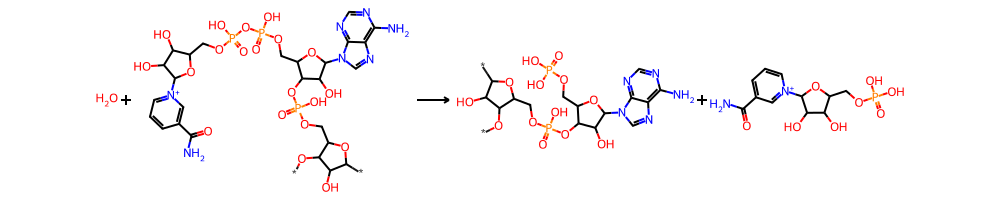

STEP #9
[('rid', 2927), ('rhea_ids', [67594]), ('imt_rules', ['rule0124_25']), ('weight', 0.6379310344827587), ('requires', {'CC(C)(COP(=O)(O)O)C(O)C(=O)NCCC(=O)NCCS': 1}), ('other_products', {'O': 1})]


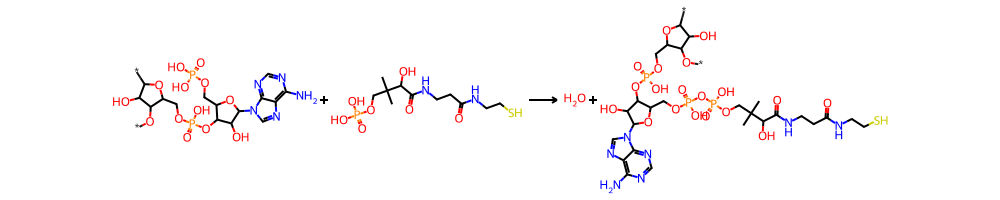

STEP #10
[('rid', 2927), ('rhea_ids', [67594]), ('imt_rules', ['rule0124_25']), ('weight', 0.9545454545454546), ('requires', {'O': 1}), ('other_products', {'*OC1C(COP(=O)(O)OC2C(COP(=O)(O)O)OC(n3cnc4c(N)ncnc43)C2O)OC(*)C1O': 1})]


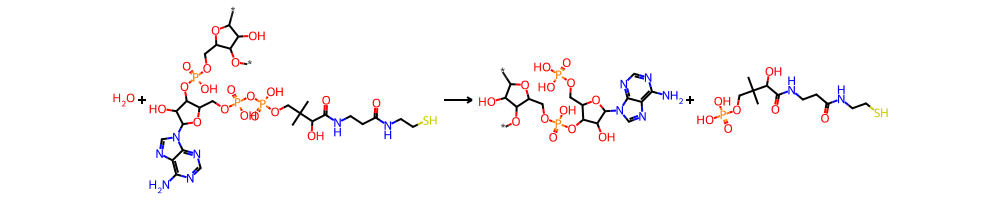

STEP #11
[('rid', 7118), ('rhea_ids', [68329]), ('imt_rules', ['rule0016_114']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'O=P(O)(O)O': 1})]


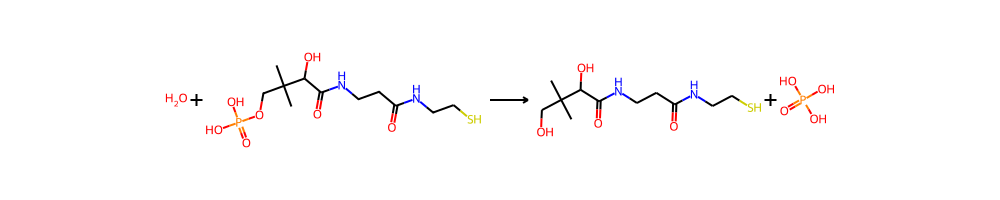

STEP #12
[('rid', 12970), ('rhea_ids', [13447]), ('imt_rules', ['rule0012_264']), ('weight', 0.9333333333333333), ('requires', {'O': 1}), ('other_products', {'NCCS': 1})]


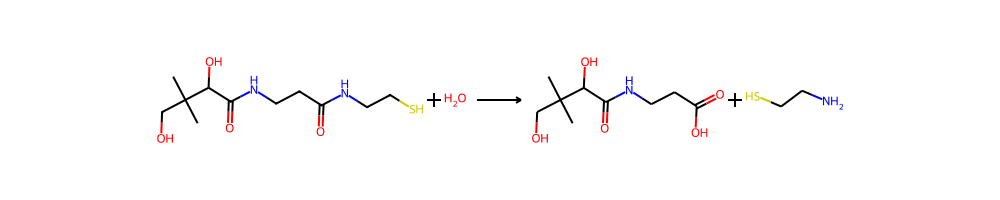

PATH FROM 2-dehydropantoate
STEP #1
[('rid', 2151), ('rhea_ids', [61293]), ('imt_rules', ['rule0002_111']), ('weight', 1.0), ('requires', {'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1': 1}), ('other_products', {'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1': 1})]


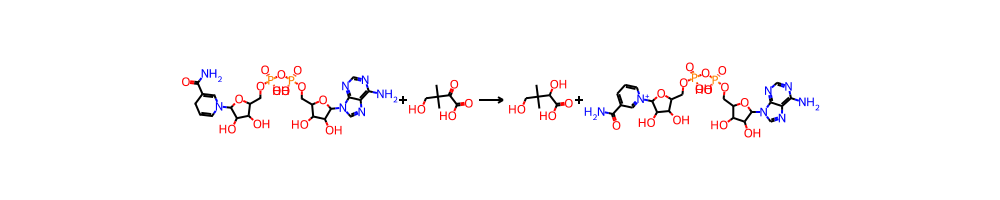

STEP #2
[('rid', 49), ('rhea_ids', [10913]), ('imt_rules', ['rule0067_1']), ('weight', 0.6), ('requires', {'NCCC(=O)O': 1, 'Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O)O)C(O)C1O': 1}), ('other_products', {'O=P(O)(O)OP(=O)(O)O': 1, 'Nc1ncnc2c1ncn2C1OC(COP(=O)(O)O)C(O)C1O': 1})]


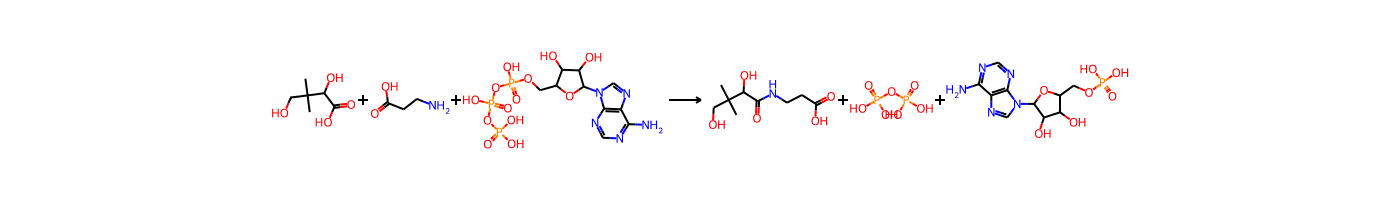

PATH FROM (R)-pantetheine
STEP #1
[('rid', 12970), ('rhea_ids', [13447]), ('imt_rules', ['rule0012_264']), ('weight', 0.9333333333333333), ('requires', {'O': 1}), ('other_products', {'NCCS': 1})]


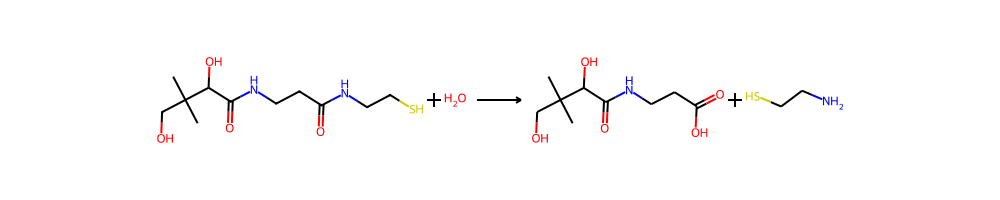

PATH FROM 3-(carbamoylamino)propanoate
STEP #1
[('rid', 13307), ('rhea_ids', [11185]), ('imt_rules', ['rule0208_2']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'O=C=O': 1, 'N': 1})]


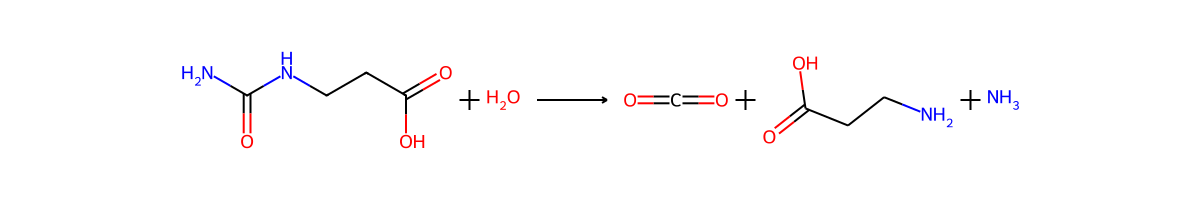

STEP #2
[('rid', 2384), ('rhea_ids', [14078]), ('imt_rules', ['rule0031_6']), ('weight', 0.8333333333333334), ('requires', {'CC(=O)C(=O)O': 1}), ('other_products', {'CC(N)C(=O)O': 1})]


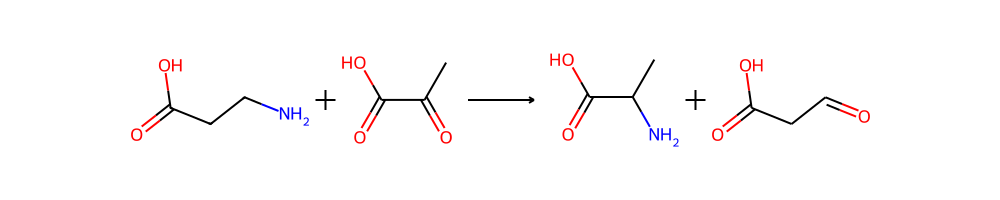

STEP #3
[('rid', 6573), ('rhea_ids', [26448]), ('imt_rules', ['rule0143_1']), ('weight', 0.1111111111111111), ('requires', {'CC(C)(COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O)C(O)C(=O)NCCC(=O)NCCS': 1, 'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1': 1}), ('other_products', {'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1': 1})]


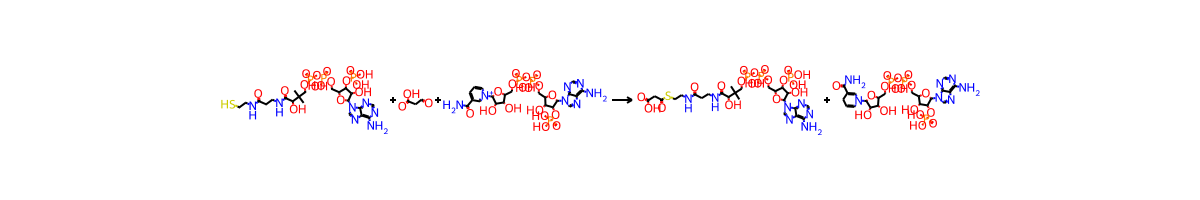

STEP #4
[('rid', 1395), ('rhea_ids', [67469]), ('imt_rules', ['rule0125_1']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'CC(C)(COP(=O)(O)O)C(O)C(=O)NCCC(=O)NCCSC(=O)CC(=O)O': 1})]


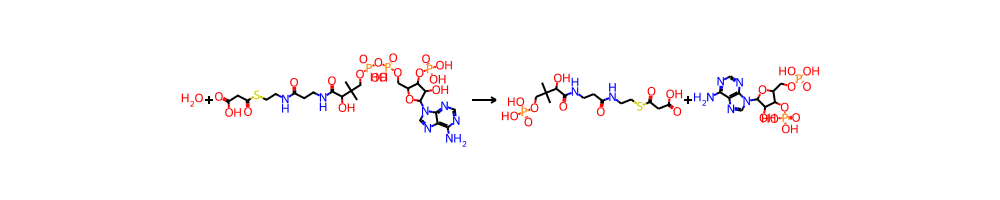

STEP #5
[('rid', 112), ('rhea_ids', [10041]), ('imt_rules', ['rule0016_042']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'O=P(O)(O)O': 1})]


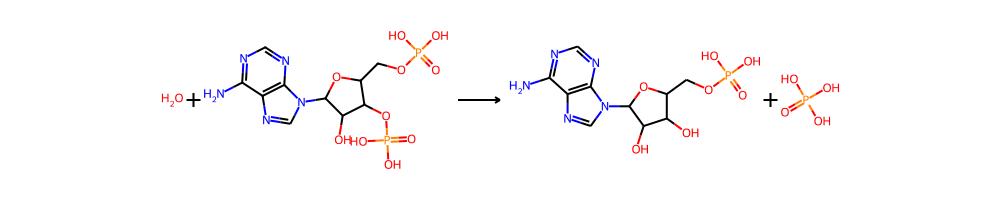

STEP #6
[('rid', 661), ('rhea_ids', [11801]), ('imt_rules', ['rule0125_1']), ('weight', 0.5227272727272727), ('requires', {'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)O)C(O)C2O)c1': 1}), ('other_products', {'O': 1})]


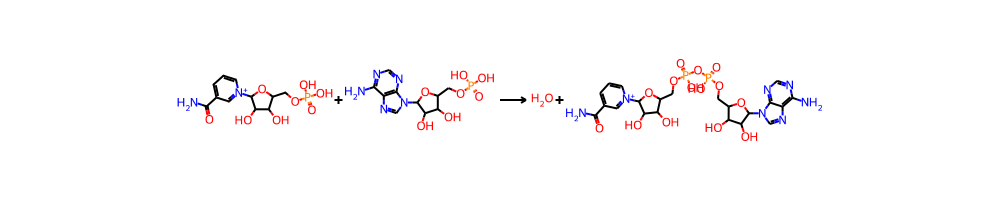

STEP #7
[('rid', 1224), ('rhea_ids', [60882, 60894]), ('imt_rules', ['rule0006_166']), ('weight', 0.7413793103448276), ('requires', {'*OC1C(COP(=O)(O)O)OC(*)C1O': 1}), ('other_products', {'O': 1})]


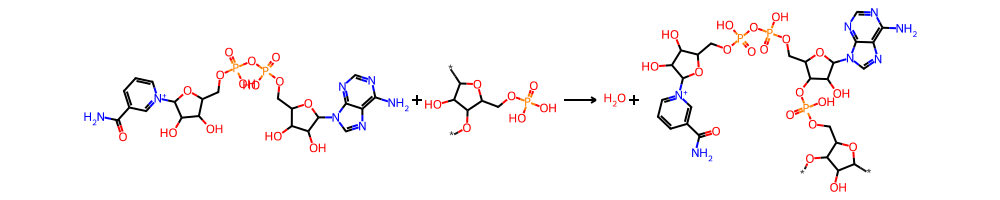

STEP #8
[('rid', 2781), ('rhea_ids', [60877]), ('imt_rules', ['rule0125_1']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)O)C(O)C2O)c1': 1})]


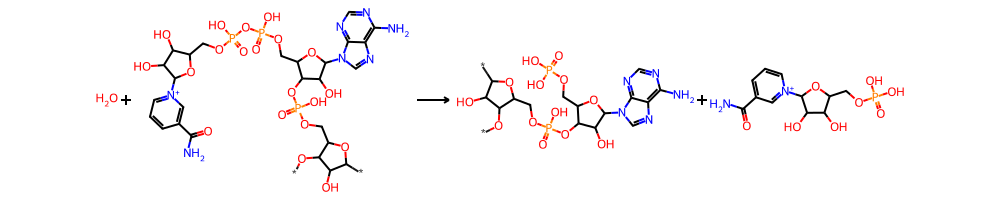

STEP #9
[('rid', 2927), ('rhea_ids', [67594]), ('imt_rules', ['rule0124_25']), ('weight', 0.6379310344827587), ('requires', {'CC(C)(COP(=O)(O)O)C(O)C(=O)NCCC(=O)NCCS': 1}), ('other_products', {'O': 1})]


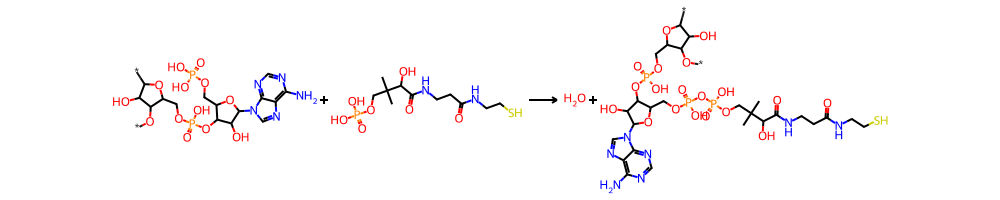

STEP #10
[('rid', 2927), ('rhea_ids', [67594]), ('imt_rules', ['rule0124_25']), ('weight', 0.9545454545454546), ('requires', {'O': 1}), ('other_products', {'*OC1C(COP(=O)(O)OC2C(COP(=O)(O)O)OC(n3cnc4c(N)ncnc43)C2O)OC(*)C1O': 1})]


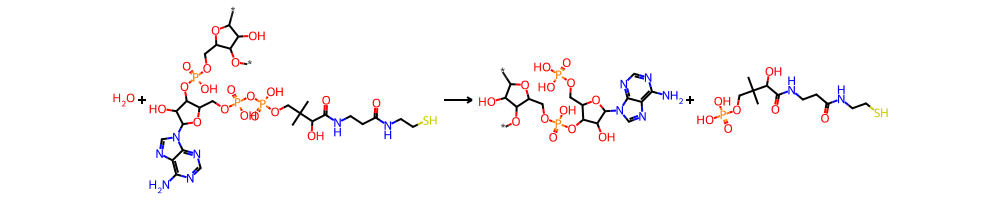

STEP #11
[('rid', 7118), ('rhea_ids', [68329]), ('imt_rules', ['rule0016_114']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'O=P(O)(O)O': 1})]


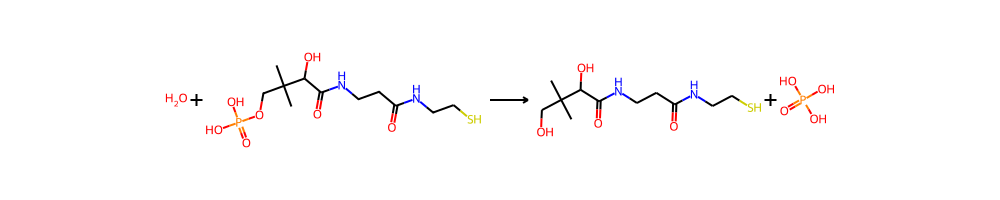

STEP #12
[('rid', 12970), ('rhea_ids', [13447]), ('imt_rules', ['rule0012_264']), ('weight', 0.9333333333333333), ('requires', {'O': 1}), ('other_products', {'NCCS': 1})]


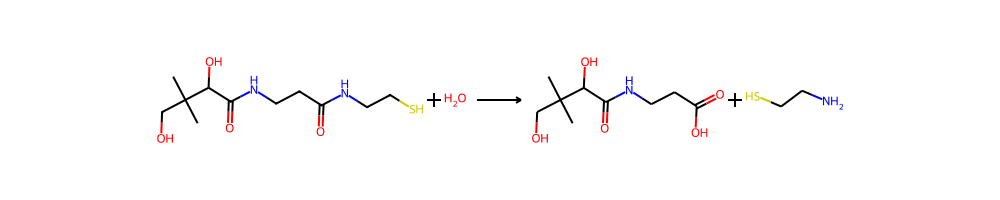

PATH FROM 3-guanidinopropanoate
STEP #1
[('rid', 2603), ('rhea_ids', [75945]), ('imt_rules', ['rule0069_16']), ('weight', 1.0), ('requires', {'NCCCC(N)C(=O)O': 1}), ('other_products', {'N=C(N)NCCCC(N)C(=O)O': 1})]


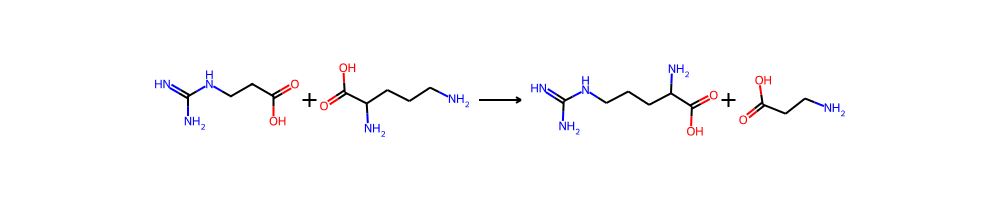

STEP #2
[('rid', 2384), ('rhea_ids', [14078]), ('imt_rules', ['rule0031_6']), ('weight', 0.8333333333333334), ('requires', {'CC(=O)C(=O)O': 1}), ('other_products', {'CC(N)C(=O)O': 1})]


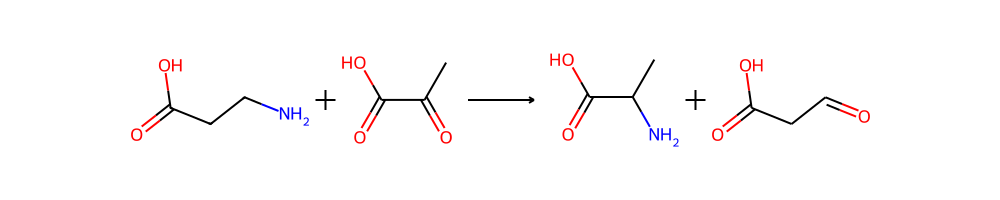

STEP #3
[('rid', 6573), ('rhea_ids', [26448]), ('imt_rules', ['rule0143_1']), ('weight', 0.1111111111111111), ('requires', {'CC(C)(COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O)C(O)C(=O)NCCC(=O)NCCS': 1, 'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1': 1}), ('other_products', {'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1': 1})]


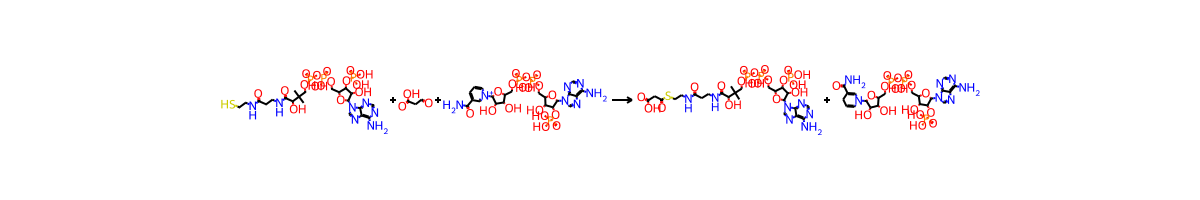

STEP #4
[('rid', 1395), ('rhea_ids', [67469]), ('imt_rules', ['rule0125_1']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'CC(C)(COP(=O)(O)O)C(O)C(=O)NCCC(=O)NCCSC(=O)CC(=O)O': 1})]


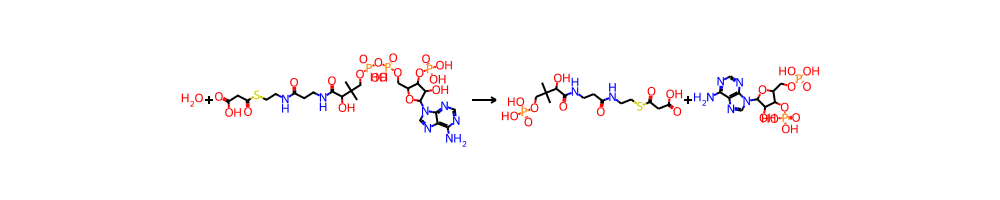

STEP #5
[('rid', 112), ('rhea_ids', [10041]), ('imt_rules', ['rule0016_042']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'O=P(O)(O)O': 1})]


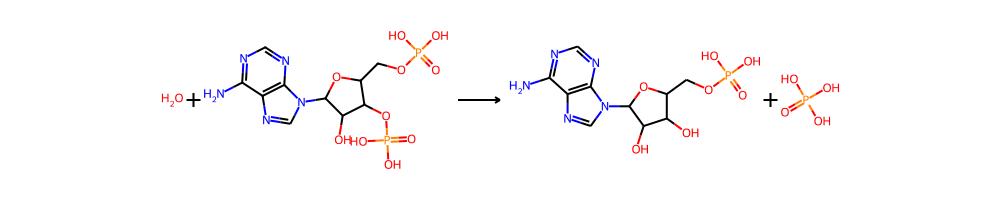

STEP #6
[('rid', 661), ('rhea_ids', [11801]), ('imt_rules', ['rule0125_1']), ('weight', 0.5227272727272727), ('requires', {'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)O)C(O)C2O)c1': 1}), ('other_products', {'O': 1})]


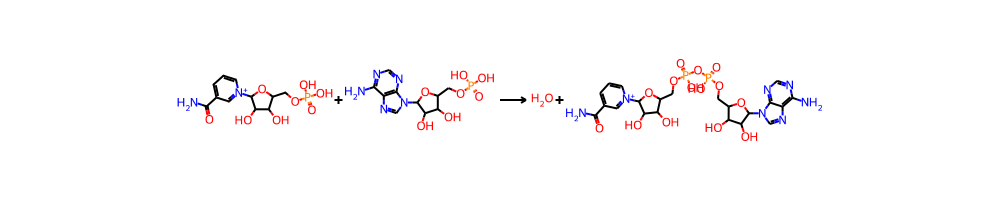

STEP #7
[('rid', 1224), ('rhea_ids', [60882, 60894]), ('imt_rules', ['rule0006_166']), ('weight', 0.7413793103448276), ('requires', {'*OC1C(COP(=O)(O)O)OC(*)C1O': 1}), ('other_products', {'O': 1})]


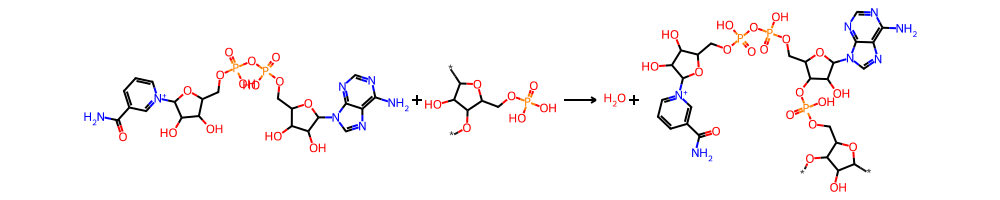

STEP #8
[('rid', 2781), ('rhea_ids', [60877]), ('imt_rules', ['rule0125_1']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)O)C(O)C2O)c1': 1})]


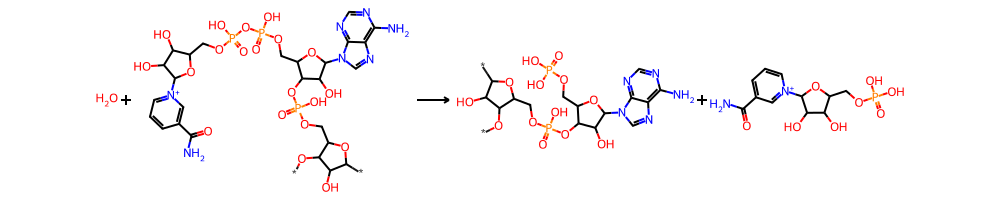

STEP #9
[('rid', 2927), ('rhea_ids', [67594]), ('imt_rules', ['rule0124_25']), ('weight', 0.6379310344827587), ('requires', {'CC(C)(COP(=O)(O)O)C(O)C(=O)NCCC(=O)NCCS': 1}), ('other_products', {'O': 1})]


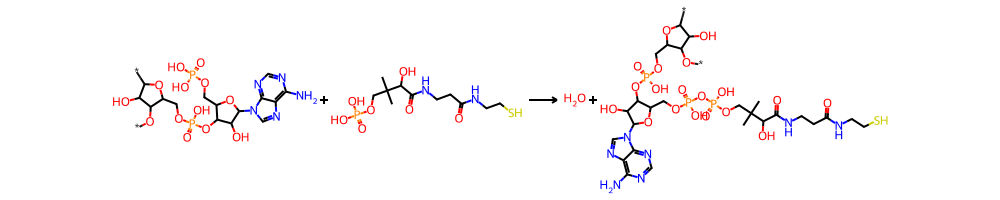

STEP #10
[('rid', 2927), ('rhea_ids', [67594]), ('imt_rules', ['rule0124_25']), ('weight', 0.9545454545454546), ('requires', {'O': 1}), ('other_products', {'*OC1C(COP(=O)(O)OC2C(COP(=O)(O)O)OC(n3cnc4c(N)ncnc43)C2O)OC(*)C1O': 1})]


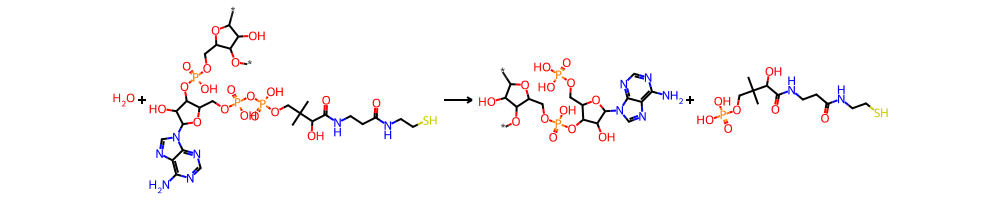

STEP #11
[('rid', 7118), ('rhea_ids', [68329]), ('imt_rules', ['rule0016_114']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'O=P(O)(O)O': 1})]


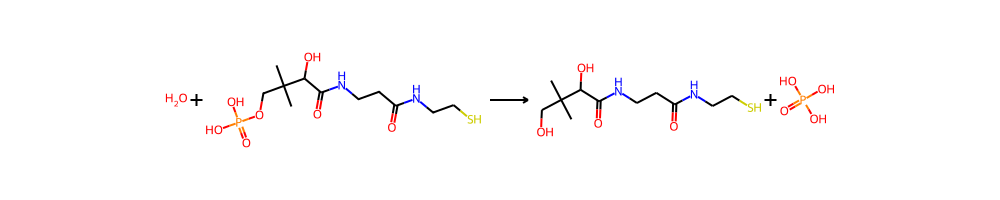

STEP #12
[('rid', 12970), ('rhea_ids', [13447]), ('imt_rules', ['rule0012_264']), ('weight', 0.9333333333333333), ('requires', {'O': 1}), ('other_products', {'NCCS': 1})]


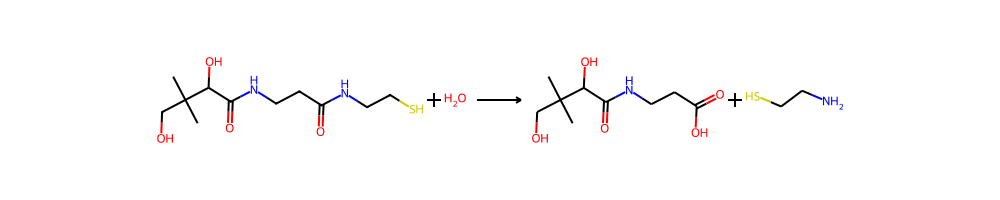

PATH FROM (R)-pantothenate
PATH FROM (R)-pantoate
STEP #1
[('rid', 49), ('rhea_ids', [10913]), ('imt_rules', ['rule0067_1']), ('weight', 0.6), ('requires', {'NCCC(=O)O': 1, 'Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O)O)C(O)C1O': 1}), ('other_products', {'O=P(O)(O)OP(=O)(O)O': 1, 'Nc1ncnc2c1ncn2C1OC(COP(=O)(O)O)C(O)C1O': 1})]


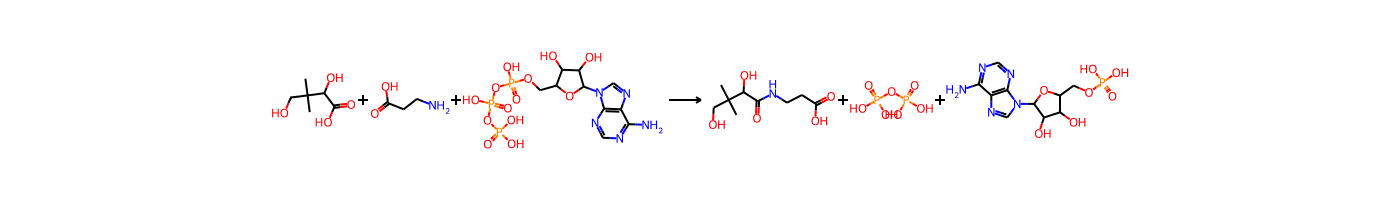

PATH FROM L-aspartate
STEP #1
[('rid', 319), ('rhea_ids', [19499]), ('imt_rules', ['rule0023_13']), ('weight', 1.0), ('requires', {}), ('other_products', {'O=C=O': 1})]


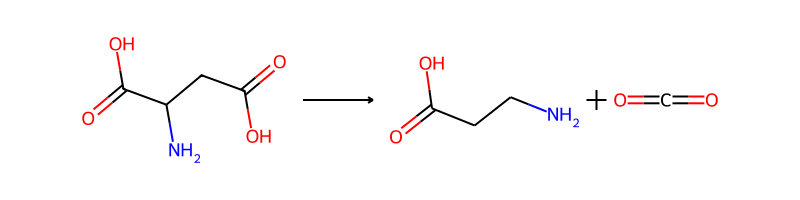

STEP #2
[('rid', 2384), ('rhea_ids', [14078]), ('imt_rules', ['rule0031_6']), ('weight', 0.8333333333333334), ('requires', {'CC(=O)C(=O)O': 1}), ('other_products', {'CC(N)C(=O)O': 1})]


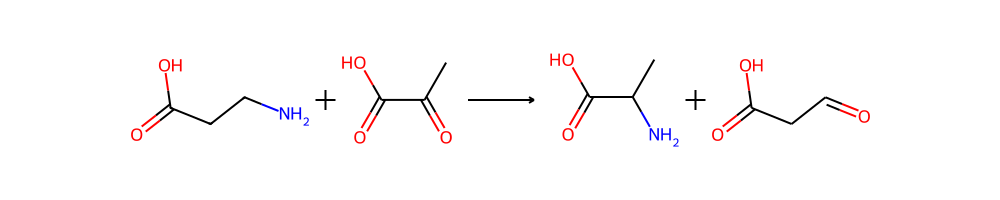

STEP #3
[('rid', 6573), ('rhea_ids', [26448]), ('imt_rules', ['rule0143_1']), ('weight', 0.1111111111111111), ('requires', {'CC(C)(COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O)C(O)C(=O)NCCC(=O)NCCS': 1, 'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1': 1}), ('other_products', {'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1': 1})]


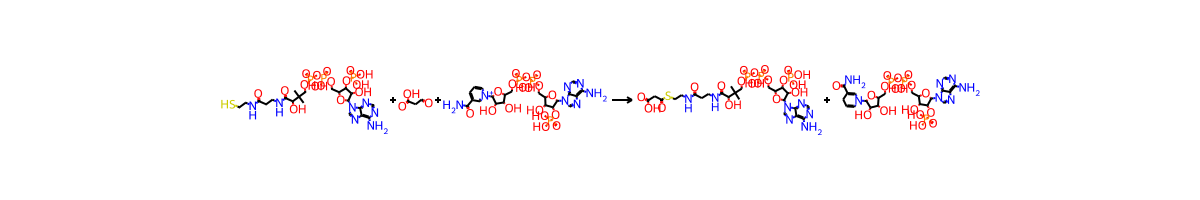

STEP #4
[('rid', 1395), ('rhea_ids', [67469]), ('imt_rules', ['rule0125_1']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'CC(C)(COP(=O)(O)O)C(O)C(=O)NCCC(=O)NCCSC(=O)CC(=O)O': 1})]


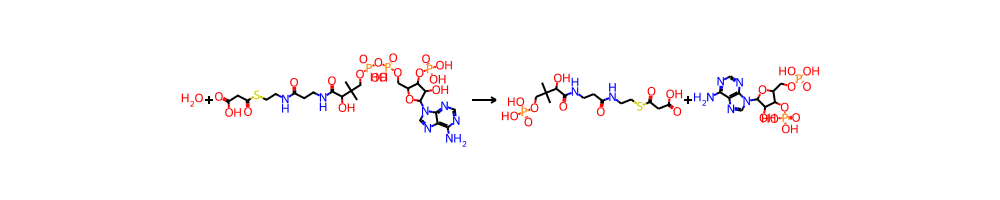

STEP #5
[('rid', 112), ('rhea_ids', [10041]), ('imt_rules', ['rule0016_042']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'O=P(O)(O)O': 1})]


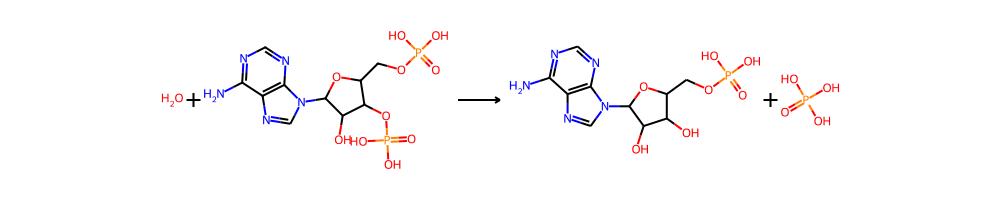

STEP #6
[('rid', 661), ('rhea_ids', [11801]), ('imt_rules', ['rule0125_1']), ('weight', 0.5227272727272727), ('requires', {'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)O)C(O)C2O)c1': 1}), ('other_products', {'O': 1})]


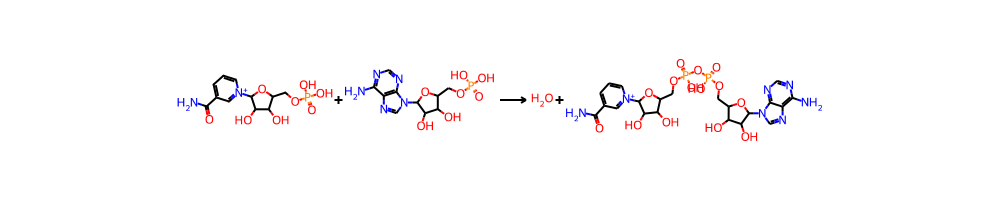

STEP #7
[('rid', 1224), ('rhea_ids', [60882, 60894]), ('imt_rules', ['rule0006_166']), ('weight', 0.7413793103448276), ('requires', {'*OC1C(COP(=O)(O)O)OC(*)C1O': 1}), ('other_products', {'O': 1})]


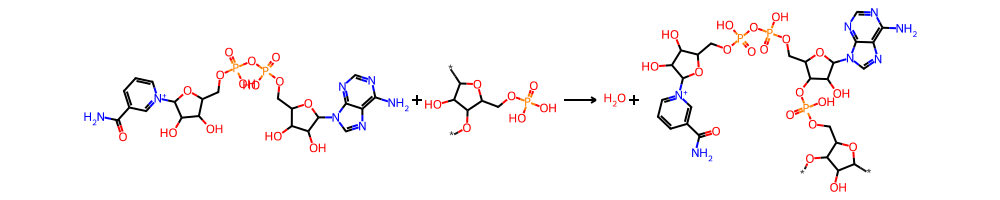

STEP #8
[('rid', 2781), ('rhea_ids', [60877]), ('imt_rules', ['rule0125_1']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)O)C(O)C2O)c1': 1})]


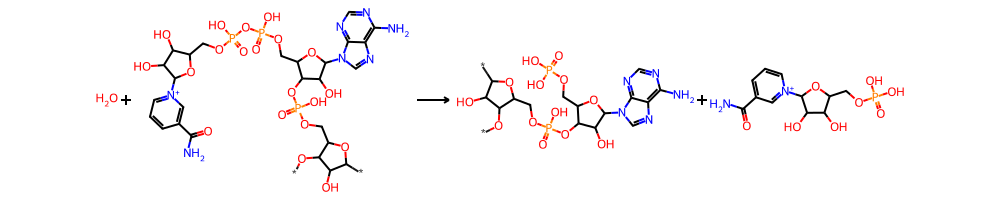

STEP #9
[('rid', 2927), ('rhea_ids', [67594]), ('imt_rules', ['rule0124_25']), ('weight', 0.6379310344827587), ('requires', {'CC(C)(COP(=O)(O)O)C(O)C(=O)NCCC(=O)NCCS': 1}), ('other_products', {'O': 1})]


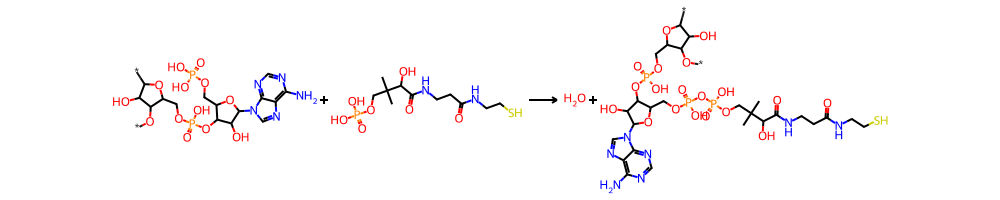

STEP #10
[('rid', 2927), ('rhea_ids', [67594]), ('imt_rules', ['rule0124_25']), ('weight', 0.9545454545454546), ('requires', {'O': 1}), ('other_products', {'*OC1C(COP(=O)(O)OC2C(COP(=O)(O)O)OC(n3cnc4c(N)ncnc43)C2O)OC(*)C1O': 1})]


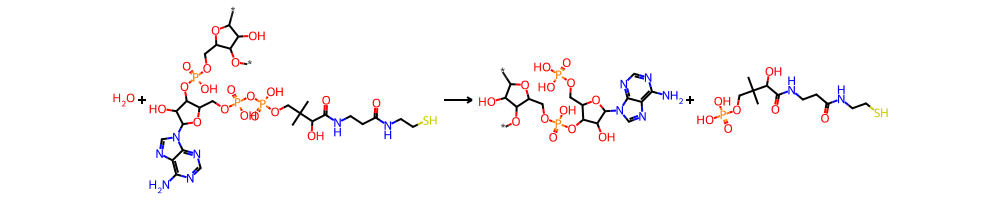

STEP #11
[('rid', 7118), ('rhea_ids', [68329]), ('imt_rules', ['rule0016_114']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'O=P(O)(O)O': 1})]


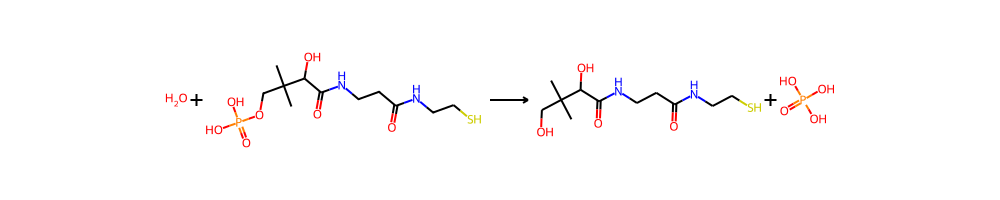

STEP #12
[('rid', 12970), ('rhea_ids', [13447]), ('imt_rules', ['rule0012_264']), ('weight', 0.9333333333333333), ('requires', {'O': 1}), ('other_products', {'NCCS': 1})]


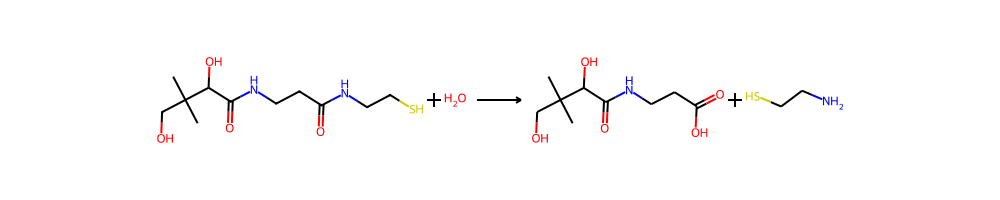

PATH FROM (R)-4'-phosphopantetheine
STEP #1
[('rid', 7118), ('rhea_ids', [68329]), ('imt_rules', ['rule0016_114']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'O=P(O)(O)O': 1})]


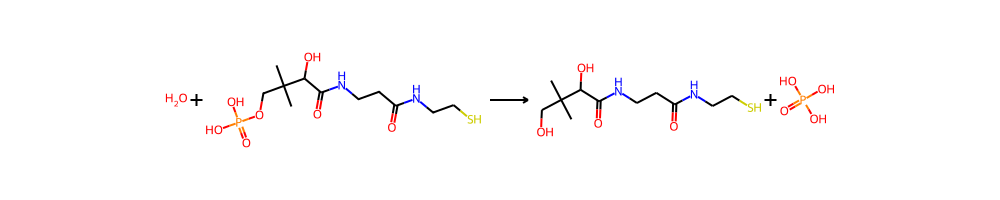

STEP #2
[('rid', 12970), ('rhea_ids', [13447]), ('imt_rules', ['rule0012_264']), ('weight', 0.9333333333333333), ('requires', {'O': 1}), ('other_products', {'NCCS': 1})]


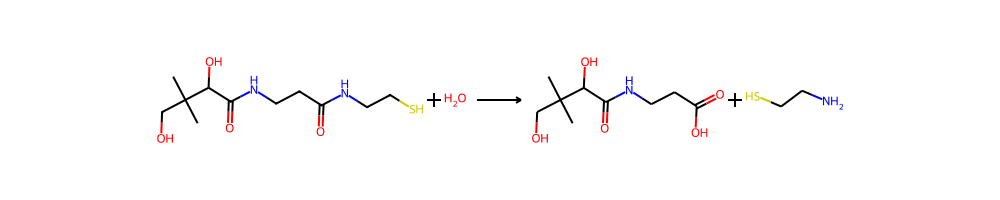

PATH FROM N-[(R)-4-phosphopantothenoyl]-L-cysteine
STEP #1
[('rid', 7923), ('rhea_ids', [19399]), ('imt_rules', ['rule0066_3']), ('weight', 0.9473684210526315), ('requires', {'O=P(O)(O)OP(=O)(O)O': 1, 'Nc1ccn(C2OC(COP(=O)(O)O)C(O)C2O)c(=O)n1': 1}), ('other_products', {'NC(CS)C(=O)O': 1, 'Nc1ccn(C2OC(COP(=O)(O)OP(=O)(O)OP(=O)(O)O)C(O)C2O)c(=O)n1': 1})]


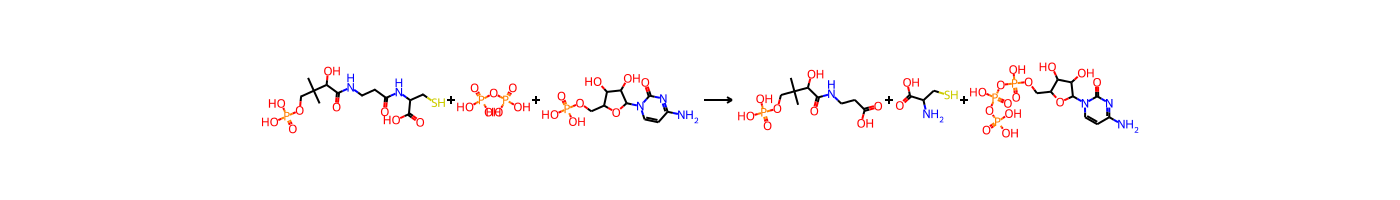

STEP #2
[('rid', 10511), ('rhea_ids', [68334]), ('imt_rules', ['rule0017_40', 'rule0017_41']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'O=P(O)(O)O': 1})]


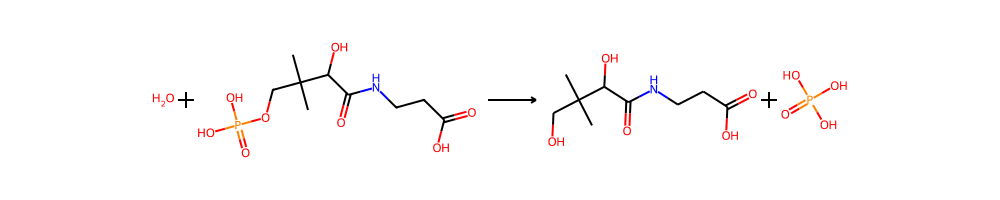

PATH FROM (R)-4'-phosphopantothenate
STEP #1
[('rid', 10511), ('rhea_ids', [68334]), ('imt_rules', ['rule0017_40', 'rule0017_41']), ('weight', 1.0), ('requires', {'O': 1}), ('other_products', {'O=P(O)(O)O': 1})]


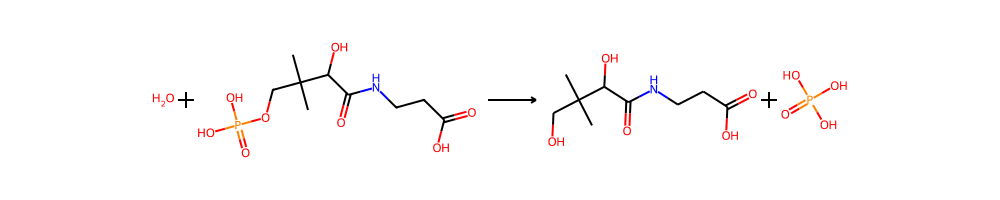

PATH FROM (R)-4-phosphopantoate
STEP #1
[('rid', 11282), ('rhea_ids', [28247]), ('imt_rules', ['rule0015_28']), ('weight', 1.0), ('requires', {'Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)O)C(O)C1O': 1}), ('other_products', {'Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O)O)C(O)C1O': 1})]


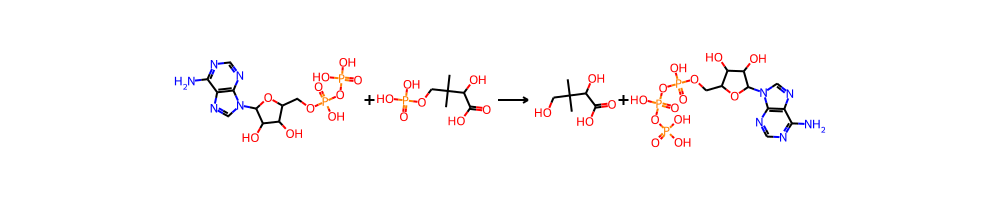

STEP #2
[('rid', 49), ('rhea_ids', [10913]), ('imt_rules', ['rule0067_1']), ('weight', 0.6), ('requires', {'NCCC(=O)O': 1, 'Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O)O)C(O)C1O': 1}), ('other_products', {'O=P(O)(O)OP(=O)(O)O': 1, 'Nc1ncnc2c1ncn2C1OC(COP(=O)(O)O)C(O)C1O': 1})]


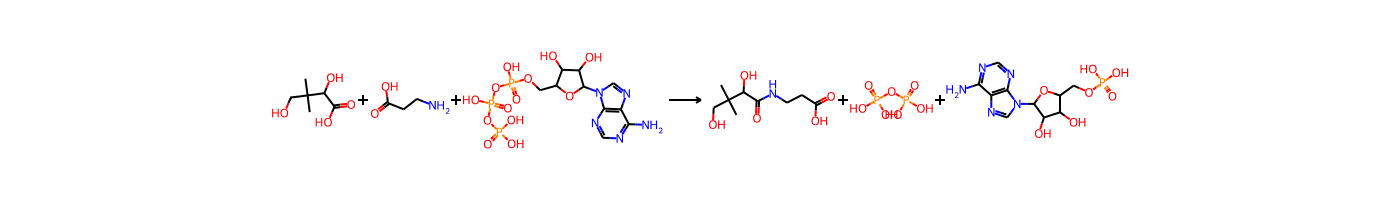

In [105]:
for i in n_hop_neighbors:
    print(f"PATH FROM {G.nodes[i]['name']}")
    show_path(i, id)